Notebook used to inspect results of Granger Causality analysis

In [27]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import math
import sys
import re
from itertools import combinations
from matplotlib_venn import venn3

# Get the project root: notebooks/AI_narrative_index
root_dir = Path.cwd().parent

# Add needed folders to the Python modules search path
sys.path.append(str(root_dir / "src" / "scripts"))
sys.path.append(str(root_dir / "src" / "visualizations"))
sys.path.append(str(root_dir / "src" / "modelling"))

# import custom functions
#rom plot_granger_causality import plot_aini_lags_by_year, plot_aini_lags_for_year
from plot_functions import plot_n_articles_with_extrema_events, plot_stock_growth
from construct_tables import export_regression_table
from compute_extrema import compute_aini_extrema
from scipy.stats import pearsonr

No control

In [28]:
# define path to variables
var_path = root_dir / "data" / "processed" / "variables"
 
# load data (S&P 500 control)
gc_c = pd.read_csv(var_path / "granger_causality_binary.csv")
gc_w0 = pd.read_csv(var_path / "granger_causality_w0.csv")
gc_w1 = pd.read_csv(var_path / "granger_causality_w1.csv")
gc_w2 = pd.read_csv(var_path / "granger_causality_w2.csv")


# create column to indicate version
gc_c["Model"] = "custom"
gc_w0["Model"] = "w0"
gc_w1["Model"] = "w1"
gc_w2["Model"] = "w2"

# merge them together
gc_all_results = pd.concat([gc_c, gc_w0, gc_w1, gc_w2], ignore_index=True)
gc_all_results["joint rej. (α=0.1)"] = gc_all_results["BH_reject_F"] & gc_all_results["BH_reject_F_HC3"]



In [29]:
# ensure no dupls
seen = {}
new_cols = []

for c in gc_all_results.columns:
    if c not in seen:
        seen[c] = 0
        new_cols.append(c)
    else:
        seen[c] += 1
        new_cols.append(f"{c}.{seen[c]}")

gc_all_results.columns = new_cols

gc_all_results.columns

# HTML output
export_regression_table(
    df=gc_all_results,
    title="Granger-Causality all Results (AINI → Returns)",
    output_filename="gc_all_results_sox_cont",
    output_format="html"
)

WindowsPath('C:/Users/PC/Desktop/Masterarbeit/AI_narrative_index/reports/tables/gc_all_results_sox_cont.html')

In [30]:
rename_map = {
    "p_x": "Lags",
    "BH_corr_F_pval": "BH empirical p",
    "BH_corr_F_pval_HC3": "BH analytical p",
    "Year": "Period"
}

# Add lag-based renames (A2R and R2A)
for i in range(1, 4):
    rename_map[f"A2R_beta_ret_{i}"] = f"β{i}"
    rename_map[f"A2R_beta_x_{i}"] = f"γ{i}"
    rename_map[f"R2A_beta_ret_{i}"] = f"β{i}"
    rename_map[f"R2A_beta_x_{i}"] = f"γ{i}"

# Apply renaming
gc_all_results = gc_all_results.rename(columns=rename_map)
gc_all_results

# drop non-stationary measures, i.e. windows in 2025; EMA_{0.2} in 2025 for costum
gc_all_results_for_report = gc_all_results[(gc_all_results["Model"] == "custom") | (gc_all_results["Period"] != "2025")]
gc_all_results_for_report  = gc_all_results_for_report[~((gc_all_results_for_report["AINI_variant"] == "EMA_02") & (gc_all_results_for_report["Period"] == "2025"))]

print(len(gc_all_results_for_report) / 2)

2790.0


In [31]:
gc_all_results_for_report_a2r = gc_all_results_for_report[gc_all_results_for_report["Direction"] == "AINI_to_RET"]
gc_all_results_for_report_a2r = gc_all_results_for_report_a2r.dropna(axis=1, how='all')

# drop non-stationary measures, i.e. windows in 2025; EMA_{0.2} in 2025 for costum
gc_all_results_for_report_a2r

,Ticker,AINI_variant,Period,Direction,β₀,β_x1_ar,β_x1,Lags,N_obs,N_boot,...,BH_reject_F,BH empirical p,BH_reject_F_HC3,BH analytical p,β_x2_ar,β_x2,β_x3_ar,β_x3,Model,joint rej. (α=0.1)
0,AAPL,EMA_02,2023,AINI_to_RET,0.001099,0.078010,0.004486,1,186,10000,...,False,0.973203,False,0.973847,NaN,NaN,NaN,NaN,custom,False
2,AAPL,EMA_08,2023,AINI_to_RET,0.000800,0.077519,0.000454,1,186,10000,...,False,0.973203,False,0.973847,NaN,NaN,NaN,NaN,custom,False
4,AAPL,normalized_AINI,2023,AINI_to_RET,0.000858,0.077650,0.001204,1,186,10000,...,False,0.973203,False,0.973847,NaN,NaN,NaN,NaN,custom,False
6,AIQ,EMA_02,2023,AINI_to_RET,-0.000071,0.102462,-0.016991,1,186,10000,...,False,0.549045,False,0.542211,NaN,NaN,NaN,NaN,custom,False
8,AIQ,EMA_08,2023,AINI_to_RET,0.000063,0.105469,-0.014697,1,186,10000,...,False,0.392661,False,0.425137,NaN,NaN,NaN,NaN,custom,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6470,TSLA,EMA_08,2024_25,AINI_to_RET,0.000010,-0.011910,0.052793,3,342,10000,...,False,0.643736,False,0.589672,-0.005393,-0.083715,-0.020141,0.062065,w2,False
6472,TSLA,normalized_AINI,2024_25,AINI_to_RET,-0.000034,-0.012983,0.036714,3,342,10000,...,False,0.643736,False,0.589672,-0.005284,-0.051728,-0.020233,0.035347,w2,False
6474,TSM,EMA_02,2024_25,AINI_to_RET,0.001731,-0.090629,0.041505,3,342,10000,...,True,0.036596,True,0.004301,0.014053,-0.492712,-0.091003,0.413345,w2,True
6476,TSM,EMA_08,2024_25,AINI_to_RET,0.001697,-0.093783,0.018901,3,342,10000,...,False,0.128787,True,0.010602,0.011239,-0.100792,-0.094978,0.025708,w2,False


In [32]:
gc_all_results


,Ticker,AINI_variant,Period,Direction,β₀,β_x1_ar,β_x1,Lags,N_obs,N_boot,...,β_x2_ar,β_x2,β_x2_ar.1,β_x2.1,β_x3_ar,β_x3,β_x3_ar.1,β_x3.1,Model,joint rej. (α=0.1)
0,AAPL,EMA_02,2023,AINI_to_RET,0.001099,0.078010,0.004486,1,186,10000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,custom,False
1,AAPL,EMA_02,2023,RET_to_AINI,NaN,NaN,NaN,1,186,10000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,custom,False
2,AAPL,EMA_08,2023,AINI_to_RET,0.000800,0.077519,0.000454,1,186,10000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,custom,False
3,AAPL,EMA_08,2023,RET_to_AINI,NaN,NaN,NaN,1,186,10000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,custom,False
4,AAPL,normalized_AINI,2023,AINI_to_RET,0.000858,0.077650,0.001204,1,186,10000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,custom,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6475,TSM,EMA_02,2024_25,RET_to_AINI,NaN,NaN,NaN,3,341,10000,...,NaN,NaN,0.020949,-0.003430,NaN,NaN,0.044571,0.005576,w2,False
6476,TSM,EMA_08,2024_25,AINI_to_RET,0.001697,-0.093783,0.018901,3,342,10000,...,0.011239,-0.100792,NaN,NaN,-0.094978,0.025708,NaN,NaN,w2,False
6477,TSM,EMA_08,2024_25,RET_to_AINI,NaN,NaN,NaN,3,341,10000,...,NaN,NaN,0.184941,-0.089844,NaN,NaN,0.132932,-0.027609,w2,False
6478,TSM,normalized_AINI,2024_25,AINI_to_RET,0.001709,-0.095122,0.017855,3,342,10000,...,0.010371,-0.075917,NaN,NaN,-0.094392,0.002693,NaN,NaN,w2,False


In [33]:
# HTML output
export_regression_table(
    df=gc_all_results,
    title="Granger-Causality all Results (AINI → Returns)",
    output_filename="gc_sp500_aini_to_ret",
    output_format="html"
)

WindowsPath('C:/Users/PC/Desktop/Masterarbeit/AI_narrative_index/reports/tables/gc_sp500_aini_to_ret.html')

In [34]:
# calculate rejection rate 

# Make sure Year and Ticker are strings
gc_all_results_for_report_a2r["Period"] = gc_all_results_for_report_a2r["Period"].astype(str)
gc_all_results_for_report_a2r["Ticker"] = gc_all_results_for_report_a2r["Ticker"].astype(str)

# Total number of models tested
total = gc_all_results_for_report_a2r["joint rej. (α=0.1)"].count()

# Number of rejections (both bootstrap + HC3 significant)
n_reject = gc_all_results_for_report_a2r["joint rej. (α=0.1)"].sum()

# Rejection rate
rejection_rate = n_reject / total * 100

print(f"Total models: {total}")
print(f"Both-method rejections: {n_reject}")
print(f"Rejection rate: {rejection_rate:.2f}%")

Total models: 2790
Both-method rejections: 103
Rejection rate: 3.69%


controlled for n art

In [35]:

# define path to variables
var_path = root_dir / "data" / "processed" / "variables"
 
# load data (S&P 500 control)
gc_c = pd.read_csv(var_path / "granger_causality_log_growth_n_art_binary.csv")
gc_w0 = pd.read_csv(var_path / "granger_causality_log_growth_n_art_w0.csv")
gc_w1 = pd.read_csv(var_path / "granger_causality_log_growth_n_art_w1.csv")
gc_w2 = pd.read_csv(var_path / "granger_causality_log_growth_n_art_w2.csv")


# create column to indicate version
gc_c["Model"] = "custom"
gc_w0["Model"] = "w0"
gc_w1["Model"] = "w1"
gc_w2["Model"] = "w2"

# merge them together
gc_all_results_art = pd.concat([gc_c, gc_w0, gc_w1, gc_w2], ignore_index=True)
gc_all_results_art["joint rej. (α=0.1)"] = gc_all_results_art["BH_reject_F"] & gc_all_results_art["BH_reject_F_HC3"]
gc_all_results_art

,Ticker,AINI_variant,Year,Direction,β₀,A2R_beta_ret_1,β_ctrl_log_growth_closed1,A2R_beta_x_1,p_x,N_obs,...,β_ctrl_log_growth_closed2.1,R2A_beta_ret_2,A2R_beta_ret_3,β_ctrl_log_growth_closed3,A2R_beta_x_3,R2A_beta_x_3,β_ctrl_log_growth_closed3.1,R2A_beta_ret_3,Model,joint rej. (α=0.1)
0,AAPL,EMA_02,2023,AINI_to_RET,0.001112,0.086547,-0.000122,0.003919,1,185,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,custom,False
1,AAPL,EMA_02,2023,RET_to_AINI,NaN,NaN,NaN,NaN,1,185,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,custom,False
2,AAPL,EMA_08,2023,AINI_to_RET,0.000735,0.085868,-0.000129,-0.001137,1,185,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,custom,False
3,AAPL,EMA_08,2023,RET_to_AINI,NaN,NaN,NaN,NaN,1,185,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,custom,False
4,AAPL,normalized_AINI,2023,AINI_to_RET,0.000792,0.086033,-0.000122,-0.000382,1,185,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,custom,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6475,TSM,EMA_02,2024_25,RET_to_AINI,NaN,NaN,NaN,NaN,3,341,...,0.000513,-0.005874,NaN,NaN,NaN,0.042935,0.001152,0.004678,w2,False
6476,TSM,EMA_08,2024_25,AINI_to_RET,0.001810,-0.091349,0.001171,0.022168,3,342,...,NaN,NaN,-0.091707,-0.006322,0.027805,NaN,NaN,NaN,w2,False
6477,TSM,EMA_08,2024_25,RET_to_AINI,NaN,NaN,NaN,NaN,3,341,...,0.004337,-0.098314,NaN,NaN,NaN,0.137166,0.002666,-0.029212,w2,False
6478,TSM,normalized_AINI,2024_25,AINI_to_RET,0.001803,-0.092524,0.001236,0.020423,3,342,...,NaN,NaN,-0.090971,-0.006288,0.004763,NaN,NaN,NaN,w2,False


In [36]:
# ensure no dupls
seen = {}
new_cols = []

for c in gc_all_results_art.columns:
    if c not in seen:
        seen[c] = 0
        new_cols.append(c)
    else:
        seen[c] += 1
        new_cols.append(f"{c}.{seen[c]}")

gc_all_results_art.columns = new_cols

# HTML output
export_regression_table(
    df=gc_all_results_art,
    title="Granger-Causality all Results (controlled for log growth daily articles)",
    output_filename="gc_all_results_article_cont",
    output_format="html"
)

WindowsPath('C:/Users/PC/Desktop/Masterarbeit/AI_narrative_index/reports/tables/gc_all_results_article_cont.html')

In [37]:
gc_all_results_art.columns

Index(['Ticker', 'AINI_variant', 'Year', 'Direction', 'β₀', 'A2R_beta_ret_1',
       'β_ctrl_log_growth_closed1', 'A2R_beta_x_1', 'p_x', 'N_obs', 'N_boot',
       'N_boot_valid', 'F_stat', 'F_stat_obs_RSS', 'Original_F_pval',
       'Empirical_F_pval', 'r2_u', 'adj_r2_u', 'β₀.1', 'R2A_beta_x_1',
       'β_ctrl_log_growth_closed1.1', 'R2A_beta_ret_1', 'BH_reject_F',
       'BH_corr_F_pval', 'BH_reject_F_HC3', 'BH_corr_F_pval_HC3',
       'A2R_beta_ret_2', 'β_ctrl_log_growth_closed2', 'A2R_beta_x_2',
       'R2A_beta_x_2', 'β_ctrl_log_growth_closed2.1', 'R2A_beta_ret_2',
       'A2R_beta_ret_3', 'β_ctrl_log_growth_closed3', 'A2R_beta_x_3',
       'R2A_beta_x_3', 'β_ctrl_log_growth_closed3.1', 'R2A_beta_ret_3',
       'Model', 'joint rej. (α=0.1)'],
      dtype='object')

Controlled for sox

In [116]:
# define path to variables
var_path = root_dir / "data" / "processed" / "variables"
 
# load data (S&P 500 control)
gc_c_sox = pd.read_csv(var_path / "granger_causality_log_growth_sox_binary.csv")
gc_w0_sox = pd.read_csv(var_path / "granger_causality_log_growth_sox_w0.csv")
gc_w1_sox = pd.read_csv(var_path / "granger_causality_log_growth_sox_w1.csv")
gc_w2_sox = pd.read_csv(var_path / "granger_causality_log_growth_sox_w2.csv")


# create column to indicate version
gc_c_sox["Model"] = "custom"
gc_w0_sox["Model"] = "w0"
gc_w1_sox["Model"] = "w1"
gc_w2_sox["Model"] = "w2"

rename_map = {
    # bookkeeping
    "p_x": "Lags",
    "Original_F_pval": "analytical P",
    "Empirical_F_pval": "empirical P",
    "BH_corr_F_pval": "BH empirical p",
    "BH_corr_F_pval_HC3": "BH analytical p",
    "Year": "Period",

    # lagged return betas (AINI → Returns)
    "A2R_beta_ret_1": "β1",
    "A2R_beta_ret_2": "β2",
    "A2R_beta_ret_3": "β3",

    # AINI lag coefficients
    "A2R_beta_x_1": "γ1",
    "A2R_beta_x_2": "γ2",
    "A2R_beta_x_3": "γ3",

    # VIX control coefficients (original + .1 versions)
    "β_ctrl_log_growth_closed1": "ζ1",
    "β_ctrl_log_growth_closed2": "ζ2",
    "β_ctrl_log_growth_closed3": "ζ3",
    "β_ctrl_log_growth_closed1.1": "ζ1",
    "β_ctrl_log_growth_closed2.1": "ζ2",
    "β_ctrl_log_growth_closed3.1": "ζ3",

    # ---- Reverse direction (Returns → AINI) ----
    "R2A_beta_ret_1": "β1",
    "R2A_beta_ret_2": "β2",
    "R2A_beta_ret_3": "β3",

    "R2A_beta_x_1": "γ1",
    "R2A_beta_x_2": "γ2",
    "R2A_beta_x_3": "γ3",
}

rename_map = {
    "p_x": "Lags",
    "BH_corr_F_pval": "BH empirical p",
    "BH_corr_F_pval_HC3": "BH analytical p",
    "Year": "Period"
}

# Add lag-based renames (A2R and R2A)
for i in range(1, 4):
    rename_map[f"A2R_beta_ret_{i}"] = f"β{i}"
    rename_map[f"A2R_beta_x_{i}"] = f"γ{i}"
    rename_map[f"R2A_beta_ret_{i}"] = f"β{i}"
    rename_map[f"R2A_beta_x_{i}"] = f"γ{i}"


# merge them together
gc_all_results_sox = pd.concat([gc_c_sox, gc_w0_sox, gc_w1_sox, gc_w2_sox], ignore_index=True)
gc_all_results_sox["joint rej. (α=0.1)"] = gc_all_results_sox["BH_reject_F"] & gc_all_results_sox["BH_reject_F_HC3"]

# Apply renaming
gc_all_results_sox = gc_all_results_sox.rename(columns=rename_map)
gc_all_results_sox
gc_all_results_sox.columns

Index(['Ticker', 'AINI_variant', 'Period', 'Direction', 'β₀', 'β1', 'γ1',
       'Lags', 'N_obs', 'N_boot', 'N_boot_valid', 'F_stat', 'F_stat_obs_RSS',
       'Original_F_pval', 'Empirical_F_pval', 'r2_u', 'adj_r2_u', 'β₀.1', 'γ1',
       'β1', 'BH_reject_F', 'BH empirical p', 'BH_reject_F_HC3',
       'BH analytical p', 'β2', 'γ2', 'γ2', 'β2', 'β3', 'γ3', 'γ3', 'β3',
       'Model', 'joint rej. (α=0.1)'],
      dtype='object')

In [117]:
# ensure no dupls
seen = {}
new_cols = []

for c in gc_all_results_sox.columns:
    if c not in seen:
        seen[c] = 0
        new_cols.append(c)
    else:
        seen[c] += 1
        new_cols.append(f"{c}.{seen[c]}")

gc_all_results_sox.columns = new_cols

gc_all_results_sox.columns

# HTML output
export_regression_table(
    df=gc_all_results_sox,
    title="Granger-Causality all Results (controlled for SOX)",
    output_filename="gc_all_results_sox_cont",
    output_format="html"
)

WindowsPath('C:/Users/PC/Desktop/Masterarbeit/AI_narrative_index/reports/tables/gc_all_results_sox_cont.html')

In [41]:
# Apply renaming
gc_all_results_sox = gc_all_results_sox.rename(columns=rename_map)
gc_all_results_sox

gc_all_results_for_report_sox = gc_all_results_sox.copy()
gc_all_results_for_report_sox

# drop non-stationary measures, i.e. windows in 2025; EMA_{0.2} in 2025 for costum
gc_all_results_for_report_sox = gc_all_results_for_report_sox[(gc_all_results_for_report_sox["Model"] == "custom") | (gc_all_results_for_report_sox["Period"] != "2025")]
gc_all_results_for_report_sox  = gc_all_results_for_report_sox[~((gc_all_results_for_report_sox["AINI_variant"] == "EMA_02") & (gc_all_results_for_report_sox["Period"] == "2025"))]

print(len(gc_all_results_for_report_sox) / 2)
gc_c_sox

2790.0


,Ticker,AINI_variant,Year,Direction,β₀,A2R_beta_ret_1,A2R_beta_x_1,p_x,N_obs,N_boot,...,BH_corr_F_pval_HC3,A2R_beta_ret_2,A2R_beta_x_2,R2A_beta_x_2,R2A_beta_ret_2,A2R_beta_ret_3,A2R_beta_x_3,R2A_beta_x_3,R2A_beta_ret_3,Model
0,AAPL,EMA_02,2023,AINI_to_RET,0.001099,0.078010,0.004486,1,186,10000,...,0.973847,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,custom
1,AAPL,EMA_02,2023,RET_to_AINI,NaN,NaN,NaN,1,186,10000,...,0.451076,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,custom
2,AAPL,EMA_08,2023,AINI_to_RET,0.000800,0.077519,0.000454,1,186,10000,...,0.973847,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,custom
3,AAPL,EMA_08,2023,RET_to_AINI,NaN,NaN,NaN,1,186,10000,...,0.451076,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,custom
4,AAPL,normalized_AINI,2023,AINI_to_RET,0.000858,0.077650,0.001204,1,186,10000,...,0.973847,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,custom
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1615,TSM,EMA_02,2024_25,RET_to_AINI,NaN,NaN,NaN,3,341,10000,...,0.011807,NaN,NaN,-0.182075,-0.010076,NaN,NaN,0.035071,0.088388,custom
1616,TSM,EMA_08,2024_25,AINI_to_RET,0.002605,-0.093318,-0.001509,3,342,10000,...,0.951514,0.005035,-0.009652,NaN,NaN,-0.100871,0.019537,NaN,NaN,custom
1617,TSM,EMA_08,2024_25,RET_to_AINI,NaN,NaN,NaN,3,341,10000,...,0.011807,NaN,NaN,-0.036734,-0.038064,NaN,NaN,0.141272,0.285435,custom
1618,TSM,normalized_AINI,2024_25,AINI_to_RET,0.002508,-0.093246,0.000294,3,342,10000,...,0.951514,0.004849,-0.005819,NaN,NaN,-0.100701,0.012857,NaN,NaN,custom


In [42]:
cols = ["AINI_variant", "Ticker", "Period", "Model"]

# ensure string dtype for merge keys
for c in cols:
    gc_all_results[c] = gc_all_results[c].astype(str)
    gc_all_results_sox[c] = gc_all_results_sox[c].astype(str)

# ensure subset of relevant columns exists in both DataFrames
missing_rows = gc_all_results.merge(
    gc_all_results_sox[cols],
    on=cols,
    how="left",
    indicator=True
).query('_merge == "left_only"') \
 .drop(columns="_merge")

# display or save
print(missing_rows)

Empty DataFrame
Columns: [Ticker, AINI_variant, Period, Direction, β₀, β_x1_ar, β_x1, Lags, N_obs, N_boot, N_boot_valid, F_stat, F_stat_obs_RSS, Original_F_pval, Empirical_F_pval, r2_u, adj_r2_u, β₀.1, β_x1_ar.1, β_x1.1, BH_reject_F, BH empirical p, BH_reject_F_HC3, BH analytical p, β_x2_ar, β_x2, β_x2_ar.1, β_x2.1, β_x3_ar, β_x3, β_x3_ar.1, β_x3.1, Model, joint rej. (α=0.1)]
Index: []

[0 rows x 34 columns]


In [43]:
gc_all_results_for_report_a2r_sox = gc_all_results_for_report_sox[gc_all_results_for_report_sox["Direction"] == "AINI_to_RET"]
gc_all_results_for_report_a2r_sox = gc_all_results_for_report_a2r_sox.dropna(axis=1, how='all')
gc_all_results_for_report_a2r_sox

,Ticker,AINI_variant,Period,Direction,β₀,β1,γ1,Lags,N_obs,N_boot,...,BH_reject_F,BH empirical p,BH_reject_F_HC3,BH analytical p,β2,γ2,β3,γ3,Model,joint rej. (α=0.1)
0,AAPL,EMA_02,2023,AINI_to_RET,0.001099,0.078010,0.004486,1,186,10000,...,False,0.972203,False,0.973847,NaN,NaN,NaN,NaN,custom,False
2,AAPL,EMA_08,2023,AINI_to_RET,0.000800,0.077519,0.000454,1,186,10000,...,False,0.972203,False,0.973847,NaN,NaN,NaN,NaN,custom,False
4,AAPL,normalized_AINI,2023,AINI_to_RET,0.000858,0.077650,0.001204,1,186,10000,...,False,0.972203,False,0.973847,NaN,NaN,NaN,NaN,custom,False
6,AIQ,EMA_02,2023,AINI_to_RET,-0.000071,0.102462,-0.016991,1,186,10000,...,False,0.541046,False,0.542211,NaN,NaN,NaN,NaN,custom,False
8,AIQ,EMA_08,2023,AINI_to_RET,0.000063,0.105469,-0.014697,1,186,10000,...,False,0.392211,False,0.425137,NaN,NaN,NaN,NaN,custom,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6470,TSLA,EMA_08,2024_25,AINI_to_RET,0.000010,-0.011910,0.052793,3,342,10000,...,False,0.640136,False,0.589672,-0.005393,-0.083715,-0.020141,0.062065,w2,False
6472,TSLA,normalized_AINI,2024_25,AINI_to_RET,-0.000034,-0.012983,0.036714,3,342,10000,...,False,0.640136,False,0.589672,-0.005284,-0.051728,-0.020233,0.035347,w2,False
6474,TSM,EMA_02,2024_25,AINI_to_RET,0.001731,-0.090629,0.041505,3,342,10000,...,True,0.035096,True,0.004301,0.014053,-0.492712,-0.091003,0.413345,w2,True
6476,TSM,EMA_08,2024_25,AINI_to_RET,0.001697,-0.093783,0.018901,3,342,10000,...,False,0.131087,True,0.010602,0.011239,-0.100792,-0.094978,0.025708,w2,False


In [44]:
# calculate rejection rate 

# Make sure Year and Ticker are strings
gc_all_results_for_report_a2r_sox["Period"] = gc_all_results_for_report_a2r_sox["Period"].astype(str)
gc_all_results_for_report_a2r_sox["Ticker"] = gc_all_results_for_report_a2r_sox["Ticker"].astype(str)

# Total number of models tested
total = gc_all_results_for_report_a2r_sox["joint rej. (α=0.1)"].count()

# Number of rejections (both bootstrap + HC3 significant)
n_reject = gc_all_results_for_report_a2r_sox["joint rej. (α=0.1)"].sum()

# Rejection rate
rejection_rate = n_reject / total * 100

print(f"Total models: {total}")
print(f"Both-method rejections: {n_reject}")
print(f"Rejection rate: {rejection_rate:.2f}%")

Total models: 2790
Both-method rejections: 103
Rejection rate: 3.69%


Controlled for S&P 500

In [45]:
# define path to variables
var_path = root_dir / "data" / "processed" / "variables"
 
# load data (S&P 500 control)
gc_c = pd.read_csv(var_path / "granger_causality_log_growth_sp500_binary.csv")
gc_w0 = pd.read_csv(var_path / "granger_causality_log_growth_sp500_w0.csv")
gc_w1 = pd.read_csv(var_path / "granger_causality_log_growth_sp500_w1.csv")
gc_w2 = pd.read_csv(var_path / "granger_causality_log_growth_sp500_w2.csv")


# create column to indicate version
gc_c["Model"] = "custom"
gc_w0["Model"] = "w0"
gc_w1["Model"] = "w1"
gc_w2["Model"] = "w2"

# merge them together
gc_all_results = pd.concat([gc_c, gc_w0, gc_w1, gc_w2], ignore_index=True)
gc_all_results_sp500 = gc_all_results.copy()
gc_all_results_sp500["joint rej. (α=0.1)"] = gc_all_results["BH_reject_F"] & gc_all_results["BH_reject_F_HC3"]
gc_all_results_sp500

,Ticker,AINI_variant,Year,Direction,β₀,A2R_beta_ret_1,β_ctrl_log_growth_closed1,A2R_beta_x_1,p_x,N_obs,...,β_ctrl_log_growth_closed2.1,R2A_beta_ret_2,A2R_beta_ret_3,β_ctrl_log_growth_closed3,A2R_beta_x_3,R2A_beta_x_3,β_ctrl_log_growth_closed3.1,R2A_beta_ret_3,Model,joint rej. (α=0.1)
0,AAPL,EMA_02,2023,AINI_to_RET,0.001114,0.085232,-0.016985,0.004594,1,186,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,custom,False
1,AAPL,EMA_02,2023,RET_to_AINI,NaN,NaN,NaN,NaN,1,186,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,custom,False
2,AAPL,EMA_08,2023,AINI_to_RET,0.000813,0.084464,-0.016323,0.000526,1,186,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,custom,False
3,AAPL,EMA_08,2023,RET_to_AINI,NaN,NaN,NaN,NaN,1,186,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,custom,False
4,AAPL,normalized_AINI,2023,AINI_to_RET,0.000872,0.084993,-0.017267,0.001286,1,186,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,custom,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6475,TSM,EMA_02,2024_25,RET_to_AINI,NaN,NaN,NaN,NaN,3,341,...,-0.117840,0.026068,NaN,NaN,NaN,0.042236,0.058646,-0.007009,w2,False
6476,TSM,EMA_08,2024_25,AINI_to_RET,0.001709,-0.110078,0.065463,0.014241,3,342,...,NaN,NaN,-0.051687,-0.182580,0.029960,NaN,NaN,NaN,w2,False
6477,TSM,EMA_08,2024_25,RET_to_AINI,NaN,NaN,NaN,NaN,3,341,...,-0.470712,0.030996,NaN,NaN,NaN,0.136684,0.228971,-0.071753,w2,False
6478,TSM,normalized_AINI,2024_25,AINI_to_RET,0.001720,-0.110436,0.060847,0.014654,3,342,...,NaN,NaN,-0.052294,-0.177571,0.005427,NaN,NaN,NaN,w2,False


In [46]:
# ensure no dupls
seen = {}
new_cols = []

for c in gc_all_results_sp500.columns:
    if c not in seen:
        seen[c] = 0
        new_cols.append(c)
    else:
        seen[c] += 1
        new_cols.append(f"{c}.{seen[c]}")

gc_all_results_sp500.columns = new_cols

gc_all_results_sp500.columns

# HTML output
export_regression_table(
    df=gc_all_results_sp500,
    title="Granger-Causality all Results (controlled for S&P500)",
    output_filename="gc_all_results_sp500_cont",
    output_format="html"
)

WindowsPath('C:/Users/PC/Desktop/Masterarbeit/AI_narrative_index/reports/tables/gc_all_results_sp500_cont.html')

In [47]:
rename_map = {
    "p_x": "Lags",
    "BH_corr_F_pval": "BH empirical p",
    "BH_corr_F_pval_HC3": "BH analytical p",
    "Year": "Period"
}

# Add lag-based renames (A2R and R2A)
for i in range(1, 4):
    rename_map[f"A2R_beta_ret_{i}"] = f"β{i}"
    rename_map[f"A2R_beta_x_{i}"] = f"γ{i}"
    rename_map[f"R2A_beta_ret_{i}"] = f"β{i}"
    rename_map[f"R2A_beta_x_{i}"] = f"γ{i}"

# Apply renaming
gc_all_results_sp500 = gc_all_results.rename(columns=rename_map)
gc_all_results_sp500

# drop non-stationary measures, i.e. windows in 2025; EMA_{0.2} in 2025 for costum
gc_all_results_sp500 = gc_all_results_sp500[(gc_all_results_sp500["Model"] == "custom") | (gc_all_results_sp500["Period"] != "2025")]
gc_all_results_sp500  = gc_all_results_sp500[~((gc_all_results_sp500["AINI_variant"] == "EMA_02") & (gc_all_results_sp500["Period"] == "2025"))]

gc_all_results_sp500_for_report = gc_all_results_sp500.copy()

print(len(gc_all_results_sp500_for_report) / 2)

gc_all_results_sp500_for_report_a2r = gc_all_results_sp500_for_report[gc_all_results_sp500_for_report["Direction"] == "AINI_to_RET"]
gc_all_results_sp500_for_report_a2r = gc_all_results_sp500_for_report_a2r.dropna(axis=1, how='all')
gc_all_results_sp500_for_report_a2r

2790.0


,Ticker,AINI_variant,Period,Direction,β₀,β1,β_ctrl_log_growth_closed1,γ1,Lags,N_obs,...,BH empirical p,BH_reject_F_HC3,BH analytical p,β2,β_ctrl_log_growth_closed2,γ2,β3,β_ctrl_log_growth_closed3,γ3,Model
0,AAPL,EMA_02,2023,AINI_to_RET,0.001114,0.085232,-0.016985,0.004594,1,186,...,0.968203,False,0.969843,NaN,NaN,NaN,NaN,NaN,NaN,custom
2,AAPL,EMA_08,2023,AINI_to_RET,0.000813,0.084464,-0.016323,0.000526,1,186,...,0.968203,False,0.969843,NaN,NaN,NaN,NaN,NaN,NaN,custom
4,AAPL,normalized_AINI,2023,AINI_to_RET,0.000872,0.084993,-0.017267,0.001286,1,186,...,0.968203,False,0.969843,NaN,NaN,NaN,NaN,NaN,NaN,custom
6,AIQ,EMA_02,2023,AINI_to_RET,0.000214,0.283873,-0.310681,-0.013236,1,186,...,0.634737,False,0.640598,NaN,NaN,NaN,NaN,NaN,NaN,custom
8,AIQ,EMA_08,2023,AINI_to_RET,0.000104,0.289831,-0.316966,-0.014252,1,186,...,0.404660,False,0.443129,NaN,NaN,NaN,NaN,NaN,NaN,custom
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6470,TSLA,EMA_08,2024_25,AINI_to_RET,0.000152,0.050024,-0.337928,0.048926,3,342,...,0.628837,False,0.625568,-0.077141,0.386437,-0.082526,0.046674,-0.383807,0.062594,w2
6472,TSLA,normalized_AINI,2024_25,AINI_to_RET,0.000114,0.049789,-0.343329,0.034110,3,342,...,0.628837,False,0.625568,-0.076894,0.384516,-0.051524,0.046815,-0.385477,0.036167,w2
6474,TSM,EMA_02,2024_25,AINI_to_RET,0.001752,-0.112838,0.086885,0.026186,3,342,...,0.033897,True,0.003421,0.025754,-0.050128,-0.487418,-0.048355,-0.179730,0.423568,w2
6476,TSM,EMA_08,2024_25,AINI_to_RET,0.001709,-0.110078,0.065463,0.014241,3,342,...,0.115388,True,0.010800,0.021683,-0.044190,-0.101522,-0.051687,-0.182580,0.029960,w2


In [48]:
# calculate rejection rate 

# Make sure Year and Ticker are strings
gc_all_results_sp500_for_report_a2r["Period"] = gc_all_results_sp500_for_report_a2r["Period"].astype(str)
gc_all_results_sp500_for_report_a2r["Ticker"] = gc_all_results_sp500_for_report_a2r["Ticker"].astype(str)

# Total number of models tested
gc_all_results_sp500_for_report_a2r["joint rej. (α=0.1)"] = gc_all_results_sp500_for_report_a2r["BH_reject_F"] & gc_all_results_sp500_for_report_a2r["BH_reject_F_HC3"]

total = gc_all_results_sp500_for_report_a2r["joint rej. (α=0.1)"].count()

# Number of rejections (both bootstrap + HC3 significant)
n_reject = gc_all_results_sp500_for_report_a2r["joint rej. (α=0.1)"].sum()

# Rejection rate
rejection_rate = n_reject / total * 100

print(f"Total models: {total}")
print(f"Both-method rejections: {n_reject}")
print(f"Rejection rate: {rejection_rate:.2f}%")
gc_all_results_for_report_a2r

Total models: 2790
Both-method rejections: 99
Rejection rate: 3.55%


,Ticker,AINI_variant,Period,Direction,β₀,β_x1_ar,β_x1,Lags,N_obs,N_boot,...,BH_reject_F,BH empirical p,BH_reject_F_HC3,BH analytical p,β_x2_ar,β_x2,β_x3_ar,β_x3,Model,joint rej. (α=0.1)
0,AAPL,EMA_02,2023,AINI_to_RET,0.001099,0.078010,0.004486,1,186,10000,...,False,0.973203,False,0.973847,NaN,NaN,NaN,NaN,custom,False
2,AAPL,EMA_08,2023,AINI_to_RET,0.000800,0.077519,0.000454,1,186,10000,...,False,0.973203,False,0.973847,NaN,NaN,NaN,NaN,custom,False
4,AAPL,normalized_AINI,2023,AINI_to_RET,0.000858,0.077650,0.001204,1,186,10000,...,False,0.973203,False,0.973847,NaN,NaN,NaN,NaN,custom,False
6,AIQ,EMA_02,2023,AINI_to_RET,-0.000071,0.102462,-0.016991,1,186,10000,...,False,0.549045,False,0.542211,NaN,NaN,NaN,NaN,custom,False
8,AIQ,EMA_08,2023,AINI_to_RET,0.000063,0.105469,-0.014697,1,186,10000,...,False,0.392661,False,0.425137,NaN,NaN,NaN,NaN,custom,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6470,TSLA,EMA_08,2024_25,AINI_to_RET,0.000010,-0.011910,0.052793,3,342,10000,...,False,0.643736,False,0.589672,-0.005393,-0.083715,-0.020141,0.062065,w2,False
6472,TSLA,normalized_AINI,2024_25,AINI_to_RET,-0.000034,-0.012983,0.036714,3,342,10000,...,False,0.643736,False,0.589672,-0.005284,-0.051728,-0.020233,0.035347,w2,False
6474,TSM,EMA_02,2024_25,AINI_to_RET,0.001731,-0.090629,0.041505,3,342,10000,...,True,0.036596,True,0.004301,0.014053,-0.492712,-0.091003,0.413345,w2,True
6476,TSM,EMA_08,2024_25,AINI_to_RET,0.001697,-0.093783,0.018901,3,342,10000,...,False,0.128787,True,0.010602,0.011239,-0.100792,-0.094978,0.025708,w2,False


In [49]:
# find divergence no control vs S&P 500

# Define key columns
keys = ["Ticker", "AINI_variant", "Period","Lags"]

# Filter both for joint rejections
a_sig = gc_all_results_sp500_for_report_a2r.loc[
    gc_all_results_sp500_for_report_a2r["joint rej. (α=0.1)"] == True, keys
]
b_sig = gc_all_results_for_report_a2r.loc[
    gc_all_results_for_report_a2r["joint rej. (α=0.1)"] == True, keys
]

# Convert to sets of unique tuples
set_a = set(map(tuple, a_sig.drop_duplicates().to_numpy()))
set_b = set(map(tuple, b_sig.drop_duplicates().to_numpy()))

# Compute differences
only_in_a = set_a - set_b
only_in_b = set_b - set_a
common = set_a & set_b

# Quick stats
print(f"Unique in SP500 (only_in_a): {len(only_in_a)}")
print(f"Unique in All (only_in_b):   {len(only_in_b)}")
print(f"Common significant pairs:    {len(common)}")

# Optional DataFrames for inspection
only_in_a_df = pd.DataFrame(list(only_in_a), columns=keys)
only_in_b_df = pd.DataFrame(list(only_in_b), columns=keys)
only_in_a_df 

Unique in SP500 (only_in_a): 13
Unique in All (only_in_b):   11
Common significant pairs:    77


,Ticker,AINI_variant,Period,Lags
0,ROBO,EMA_08,2024_25,3
1,TSM,normalized_AINI,2023_24_25,3
2,BOTZ,normalized_AINI,2024_25,3
3,NVDA,EMA_08,2025,3
4,ARKQ,EMA_08,2023_24,3
5,ROBO,normalized_AINI,2024_25,3
6,AIQ,EMA_08,2025,1
7,NVDA,normalized_AINI,2025,3
8,AVGO,normalized_AINI,2025,1
9,ARKQ,normalized_AINI,2023_24,3


In [50]:
# HTML output
export_regression_table(
    df=gc_all_results_sp500,
    title="Granger-Causality all Results (AINI → Returns, controlled for S&P500)",
    output_filename="gc_all_results_sp500_cont",
    output_format="html"
)

WindowsPath('C:/Users/PC/Desktop/Masterarbeit/AI_narrative_index/reports/tables/gc_all_results_sp500_cont.html')

In [51]:
# indicate significance
gc_all_results_sp500["joint rej. (α=0.1)"] = gc_all_results_sp500["BH_reject_F"] & gc_all_results_sp500["BH_reject_F_HC3"]

In [52]:
# subset by direction
sp500_aini_to_ret = gc_all_results_sp500[gc_all_results_sp500["Direction"] == "AINI_to_RET"]
sp500_ret_to_aini = gc_all_results_sp500[gc_all_results_sp500["Direction"] == "RET_to_AINI"]

# cols to keep
keep_a2r = [
    "Model", "AINI_variant","adj_r2_u", "Ticker", "Period", "Lags",
    "β1", "β2", "β3",
    "γ1", "γ2", "γ3",
    "BH empirical p", "BH analytical p", "joint rej. (α=0.1)"
]

keep_r2a = [
    "Model", "AINI_variant","adj_r2_u", "Ticker", "Period", "Lags",
    "β1", "β2", "β3",
    "γ1", "γ2", "γ3",
    "BH empirical p", "BH analytical p", "joint rej. (α=0.1)"
]

# subset
sp500_aini_to_ret_sub = sp500_aini_to_ret[keep_a2r]
sp500_ret_to_aini_sub = sp500_ret_to_aini[keep_r2a]

sp500_aini_to_ret.columns

Index(['Ticker', 'AINI_variant', 'Period', 'Direction', 'β₀', 'β1',
       'β_ctrl_log_growth_closed1', 'γ1', 'Lags', 'N_obs', 'N_boot',
       'N_boot_valid', 'F_stat', 'F_stat_obs_RSS', 'Original_F_pval',
       'Empirical_F_pval', 'r2_u', 'adj_r2_u', 'β₀.1', 'γ1',
       'β_ctrl_log_growth_closed1.1', 'β1', 'BH_reject_F', 'BH empirical p',
       'BH_reject_F_HC3', 'BH analytical p', 'β2', 'β_ctrl_log_growth_closed2',
       'γ2', 'γ2', 'β_ctrl_log_growth_closed2.1', 'β2', 'β3',
       'β_ctrl_log_growth_closed3', 'γ3', 'γ3', 'β_ctrl_log_growth_closed3.1',
       'β3', 'Model', 'joint rej. (α=0.1)'],
      dtype='object')

In [53]:
sp500_aini_to_ret_sub

,Model,AINI_variant,adj_r2_u,Ticker,Period,Lags,β1,β1,β2,β2,...,β3,γ1,γ1,γ2,γ2,γ3,γ3,BH empirical p,BH analytical p,joint rej. (α=0.1)
0,custom,EMA_02,-0.010187,AAPL,2023,1,0.085232,NaN,NaN,NaN,...,NaN,0.004594,NaN,NaN,NaN,NaN,NaN,0.968203,0.969843,False
2,custom,EMA_08,-0.010336,AAPL,2023,1,0.084464,NaN,NaN,NaN,...,NaN,0.000526,NaN,NaN,NaN,NaN,NaN,0.968203,0.969843,False
4,custom,normalized_AINI,-0.010269,AAPL,2023,1,0.084993,NaN,NaN,NaN,...,NaN,0.001286,NaN,NaN,NaN,NaN,NaN,0.968203,0.969843,False
6,custom,EMA_02,0.006118,AIQ,2023,1,0.283873,NaN,NaN,NaN,...,NaN,-0.013236,NaN,NaN,NaN,NaN,NaN,0.634737,0.640598,False
8,custom,EMA_08,0.012197,AIQ,2023,1,0.289831,NaN,NaN,NaN,...,NaN,-0.014252,NaN,NaN,NaN,NaN,NaN,0.404660,0.443129,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6470,w2,EMA_08,-0.002265,TSLA,2024_25,3,0.050024,NaN,-0.077141,NaN,...,NaN,0.048926,NaN,-0.082526,NaN,0.062594,NaN,0.628837,0.625568,False
6472,w2,normalized_AINI,-0.004218,TSLA,2024_25,3,0.049789,NaN,-0.076894,NaN,...,NaN,0.034110,NaN,-0.051524,NaN,0.036167,NaN,0.628837,0.625568,False
6474,w2,EMA_02,0.028445,TSM,2024_25,3,-0.112838,NaN,0.025754,NaN,...,NaN,0.026186,NaN,-0.487418,NaN,0.423568,NaN,0.033897,0.003421,True
6476,w2,EMA_08,0.015761,TSM,2024_25,3,-0.110078,NaN,0.021683,NaN,...,NaN,0.014241,NaN,-0.101522,NaN,0.029960,NaN,0.115388,0.010800,False


In [54]:
# calculate rejection rate 

# Make sure Year and Ticker are strings
sp500_aini_to_ret_sub["Period"] = sp500_aini_to_ret_sub["Period"].astype(str)
sp500_aini_to_ret_sub["Ticker"] = sp500_aini_to_ret_sub["Ticker"].astype(str)

# 

# Total number of models tested
total = sp500_aini_to_ret_sub["joint rej. (α=0.1)"].count()

# Number of rejections (both bootstrap + HC3 significant)
n_reject = sp500_aini_to_ret_sub["joint rej. (α=0.1)"].sum()

# Rejection rate
rejection_rate = n_reject / total * 100

print(f"Total models: {total}")
print(f"Both-method rejections: {n_reject}")
print(f"Rejection rate: {rejection_rate:.2f}%")


Total models: 2790
Both-method rejections: 99
Rejection rate: 3.55%


C:\Users\PC\AppData\Local\Temp\ipykernel_8984\654672437.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp500_aini_to_ret_sub["Period"] = sp500_aini_to_ret_sub["Period"].astype(str)
C:\Users\PC\AppData\Local\Temp\ipykernel_8984\654672437.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp500_aini_to_ret_sub["Ticker"] = sp500_aini_to_ret_sub["Ticker"].astype(str)


In [55]:
# calculate rejection rate 

# Make sure Year and Ticker are strings
sp500_ret_to_aini_sub["Period"] = sp500_ret_to_aini_sub["Period"].astype(str)
sp500_ret_to_aini_sub["Ticker"] = sp500_ret_to_aini_sub["Ticker"].astype(str)

# Total number of models tested
total = sp500_ret_to_aini_sub["joint rej. (α=0.1)"].count()

# Number of rejections (both bootstrap + HC3 significant)
n_reject = sp500_ret_to_aini_sub["joint rej. (α=0.1)"].sum()

# Rejection rate
rejection_rate = n_reject / total * 100

print(f"Total models: {total}")
print(f"Both-method rejections: {n_reject}")
print(f"Rejection rate: {rejection_rate:.2f}%")
sp500_ret_to_aini_sub

Total models: 2790
Both-method rejections: 128
Rejection rate: 4.59%


C:\Users\PC\AppData\Local\Temp\ipykernel_8984\28054366.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp500_ret_to_aini_sub["Period"] = sp500_ret_to_aini_sub["Period"].astype(str)
C:\Users\PC\AppData\Local\Temp\ipykernel_8984\28054366.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp500_ret_to_aini_sub["Ticker"] = sp500_ret_to_aini_sub["Ticker"].astype(str)


,Model,AINI_variant,adj_r2_u,Ticker,Period,Lags,β1,β1,β2,β2,...,β3,γ1,γ1,γ2,γ2,γ3,γ3,BH empirical p,BH analytical p,joint rej. (α=0.1)
1,custom,EMA_02,0.584317,AAPL,2023,1,NaN,-0.186327,NaN,NaN,...,NaN,NaN,0.753046,NaN,NaN,NaN,NaN,0.343666,0.298034,False
3,custom,EMA_08,0.048446,AAPL,2023,1,NaN,-0.618600,NaN,NaN,...,NaN,NaN,0.233846,NaN,NaN,NaN,NaN,0.343666,0.298034,False
5,custom,normalized_AINI,-0.003000,AAPL,2023,1,NaN,-0.664800,NaN,NaN,...,NaN,NaN,0.082852,NaN,NaN,NaN,NaN,0.343666,0.298034,False
7,custom,EMA_02,0.589375,AIQ,2023,1,NaN,0.535814,NaN,NaN,...,NaN,NaN,0.767524,NaN,NaN,NaN,NaN,0.078292,0.092471,True
9,custom,EMA_08,0.048023,AIQ,2023,1,NaN,0.995455,NaN,NaN,...,NaN,NaN,0.241385,NaN,NaN,NaN,NaN,0.288971,0.260867,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6471,w2,EMA_08,0.273562,TSLA,2024_25,3,NaN,-0.053359,NaN,0.011756,...,0.028972,NaN,0.334777,NaN,0.188956,NaN,0.129196,0.796320,0.796945,False
6473,w2,normalized_AINI,0.161234,TSLA,2024_25,3,NaN,-0.061750,NaN,0.024564,...,0.031773,NaN,0.192481,NaN,0.238794,NaN,0.125661,0.796320,0.796945,False
6475,w2,EMA_02,0.823329,TSM,2024_25,3,NaN,0.023109,NaN,0.026068,...,-0.007009,NaN,0.861538,NaN,0.020121,NaN,0.042236,0.737626,0.791279,False
6477,w2,EMA_08,0.275765,TSM,2024_25,3,NaN,0.115066,NaN,0.030996,...,-0.071753,NaN,0.331464,NaN,0.190979,NaN,0.136684,0.737626,0.791279,False


In [56]:
# subset significant results
sp500_aini_to_ret_sig = sp500_aini_to_ret_sub[sp500_aini_to_ret_sub["joint rej. (α=0.1)"] == True]
sp500_ret_to_aini_sig = sp500_ret_to_aini_sub[sp500_ret_to_aini_sub["joint rej. (α=0.1)"] == True]
# drop 0 value cols
sp500_ret_to_aini_sig = sp500_ret_to_aini_sig.dropna(axis=1,how="all")

# Coerce β columns to numeric 
sp500_ret_to_aini_sig[["β1","β2","β3"]] = (
    sp500_ret_to_aini_sig[["β1","β2","β3"]]
    .apply(pd.to_numeric, errors="coerce")
)
sp500_ret_to_aini_sig

,Model,AINI_variant,adj_r2_u,Ticker,Period,Lags,β1,β2,β3,γ1,γ2,γ3,BH empirical p,BH analytical p,joint rej. (α=0.1)
7,custom,EMA_02,0.589375,AIQ,2023,1,0.535814,NaN,NaN,0.767524,NaN,NaN,0.078292,0.092471,True
237,custom,EMA_08,0.446919,META,2025,1,-0.686227,NaN,NaN,0.669462,NaN,NaN,0.078592,0.028000,True
239,custom,normalized_AINI,0.298908,META,2025,1,-0.846222,NaN,NaN,0.543393,NaN,NaN,0.078592,0.028000,True
459,custom,EMA_08,0.266795,AIQ,2024_25,1,-1.077423,NaN,NaN,0.517131,NaN,NaN,0.026247,0.010756,True
461,custom,normalized_AINI,0.136560,AIQ,2024_25,1,-1.380261,NaN,NaN,0.362347,NaN,NaN,0.026247,0.010756,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5943,w2,EMA_08,0.042986,AAPL,2023,3,0.436939,-0.811732,0.070738,0.185754,-0.064985,-0.046186,0.055644,0.094514,True
5945,w2,normalized_AINI,0.026425,AAPL,2023,3,0.537350,-1.050945,0.099984,0.074694,-0.064345,-0.059091,0.055644,0.094514,True
6001,w2,EMA_02,0.492435,MSFT,2023,3,0.100730,-0.135700,-0.032801,0.755080,-0.062368,-0.045007,0.088691,0.078681,True
6003,w2,EMA_08,0.038983,MSFT,2023,3,0.476672,-0.299380,0.089810,0.193238,-0.034317,-0.046147,0.054295,0.077980,True


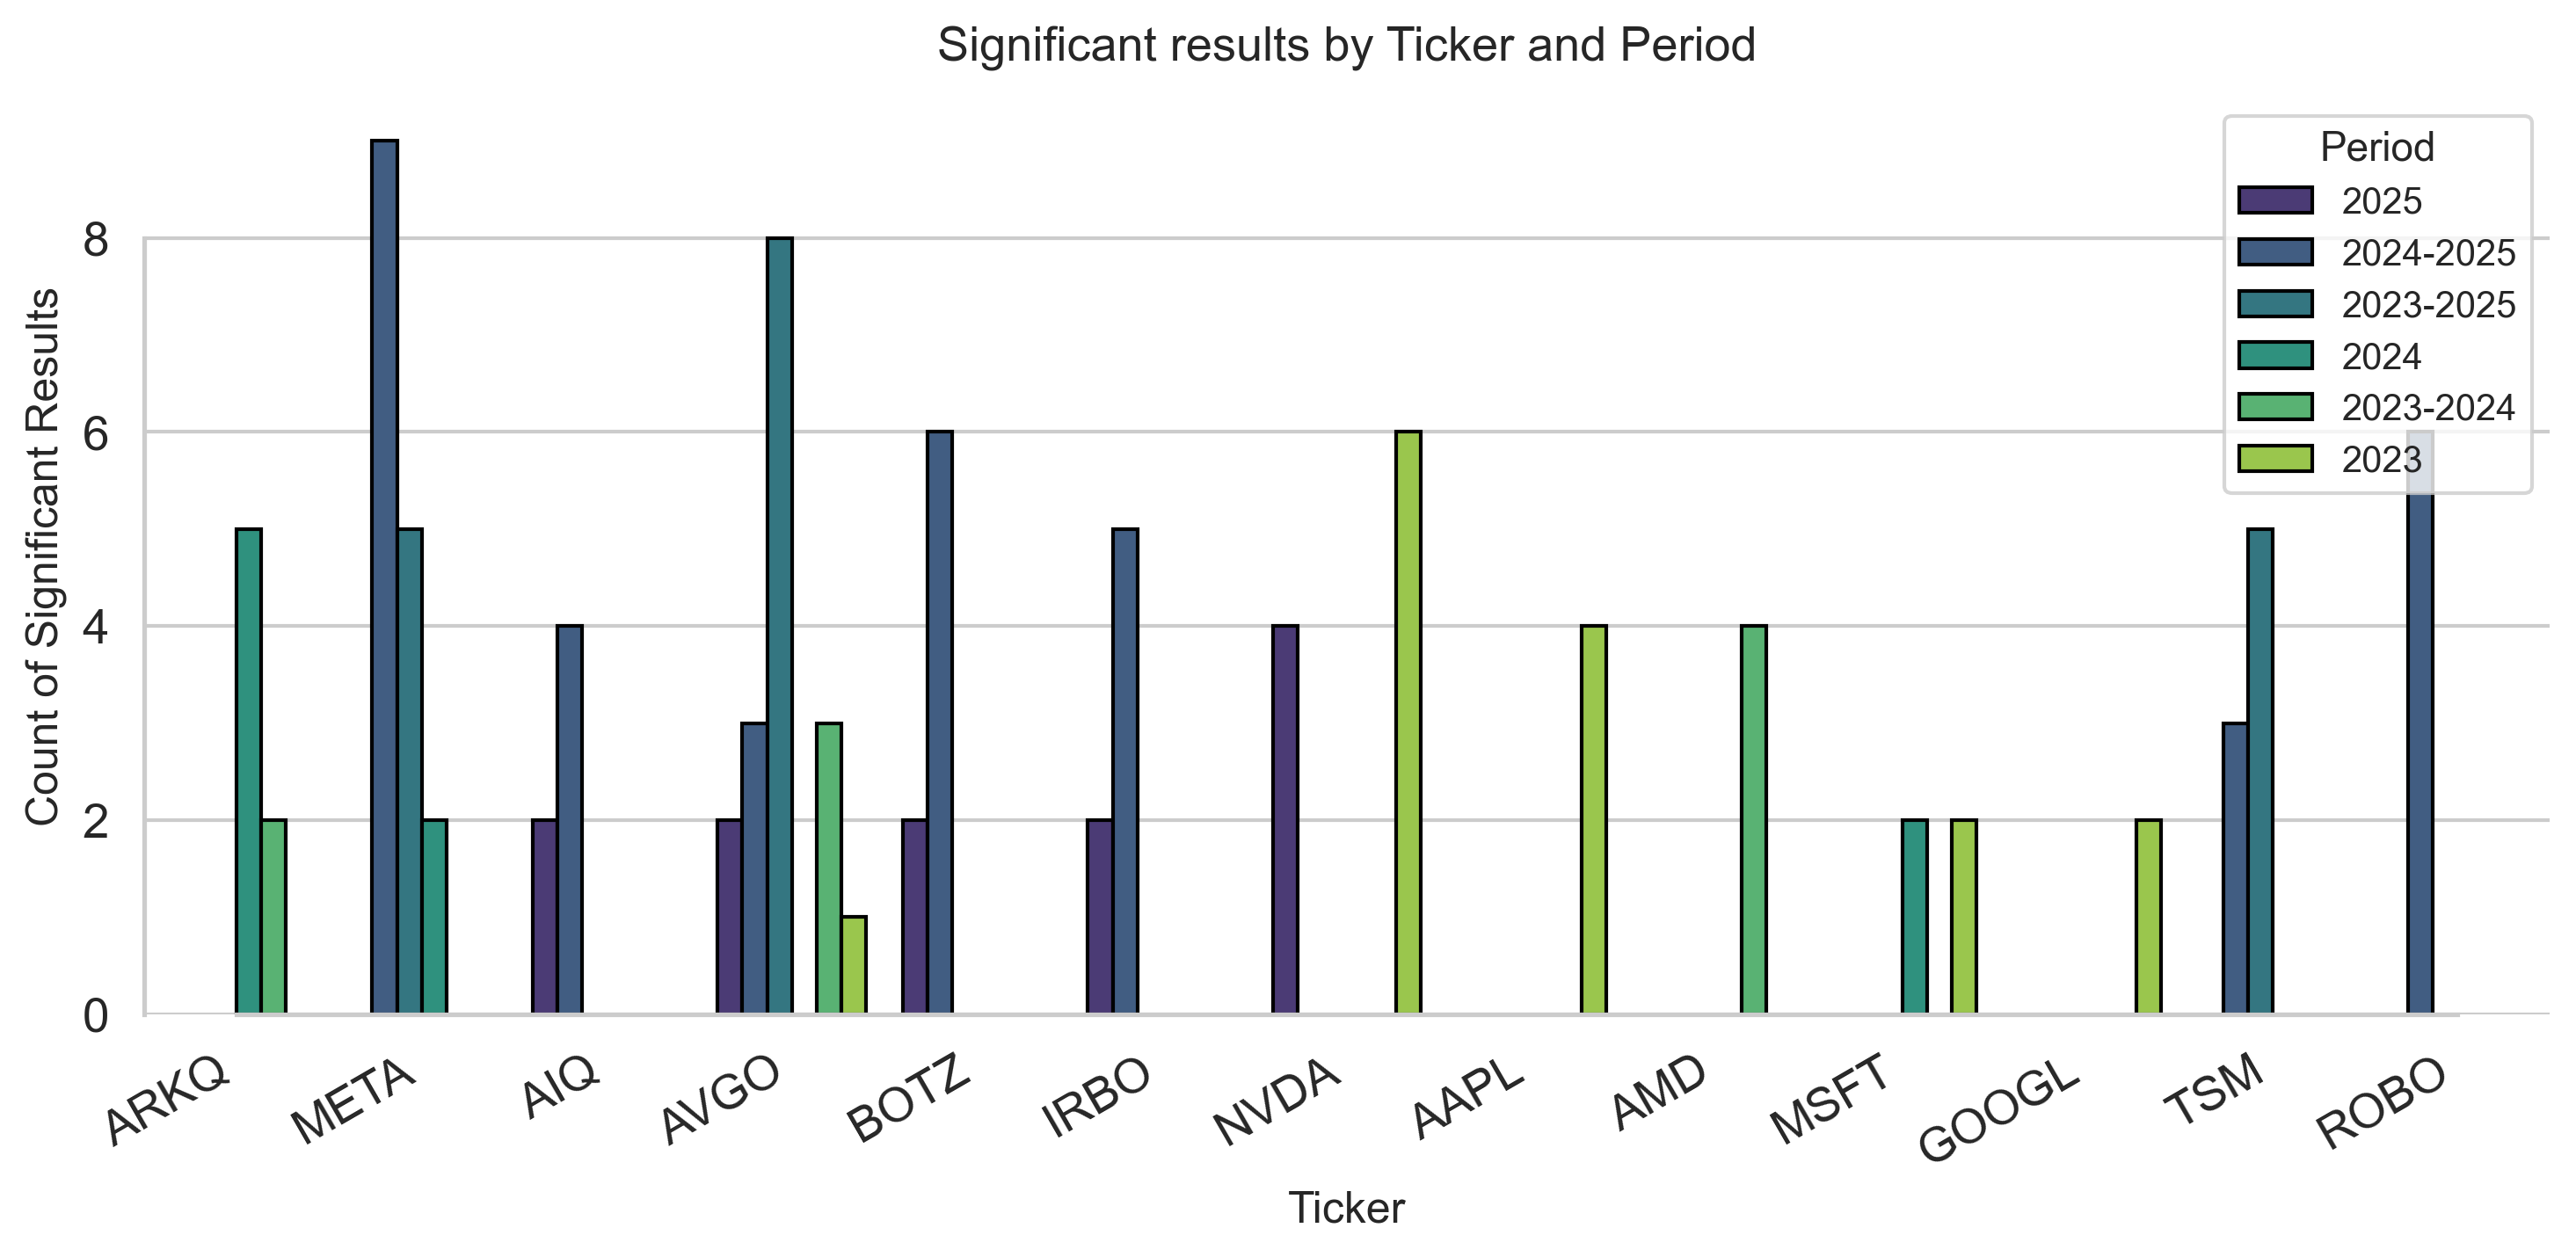

In [57]:
df = sp500_aini_to_ret_sig.copy()
df["Period"] = df["Period"].replace({
    "2023_24_25": "2023-2025",
    "2024_25": "2024-2025",
    "2023_24": "2023-2024"
}).astype(str)
df["Ticker"] = df["Ticker"].astype(str)

#  build order 
def period_key(p: str):
    years = list(map(int, re.findall(r"\d{4}", p)))
    if len(years) == 1:
        years = [years[0], years[0]]
    start, end = years[0], years[-1]
    return (end, start) 

periods = sorted(df["Period"].unique(), key=period_key, reverse=True)
df["Period"] = pd.Categorical(df["Period"], categories=periods, ordered=True)

# plot 
sns.set_theme(style="whitegrid", font_scale=1.2)
plt.figure(figsize=(10, 5), dpi=300)

ax = sns.countplot(
    data=df,
    x="Ticker",
    hue="Period",
    hue_order=periods,                          
    palette=sns.color_palette("viridis", n_colors=len(periods)),
    edgecolor="black"
)

ax.set_title("Significant results by Ticker and Period", fontsize=13, pad=10)
ax.set_xlabel("Ticker", fontsize=12)
ax.set_ylabel("Count of Significant Results", fontsize=12)
ax.legend(title="Period", title_fontsize=11, fontsize=10, loc="upper right", frameon=True)

plt.xticks(rotation=30, ha="right")
sns.despine(trim=True)
plt.tight_layout()
plt.savefig(root_dir / "reports/figures/sp500_aini_to_ret_sig_counts.png", dpi=600, bbox_inches="tight")
plt.show()


In [58]:
# group by model
model_group_tickers = (
    sp500_aini_to_ret_sig
    .groupby(["Ticker"])
    .size()
    .reset_index(name="jointly rejected at α=0.1")
    .sort_values(by="jointly rejected at α=0.1",ascending=False)
)


# print
print(model_group_tickers)

   Ticker  jointly rejected at α=0.1
4    AVGO                         17
8    META                         16
10   NVDA                         10
5    BOTZ                          8
12    TSM                          8
3    ARKQ                          7
7    IRBO                          7
1     AIQ                          6
11   ROBO                          6
0    AAPL                          4
2     AMD                          4
9    MSFT                          4
6   GOOGL                          2


In [59]:
# group by model all
model_group_tickers = (
    sp500_aini_to_ret
    .groupby(["Model"])
    .size()
    .reset_index(name="jointly rejected at α=0.1")
    .sort_values(by="jointly rejected at α=0.1",ascending=False)
)


# print
print(model_group_tickers)

    Model  jointly rejected at α=0.1
0  custom                        765
1      w0                        675
2      w1                        675
3      w2                        675


In [60]:
# group by period
model_group_period = (
    sp500_aini_to_ret_sig
    .groupby(["Period"])
    .size()
    .reset_index(name="jointly rejected at α=0.1")
    .sort_values(by="jointly rejected at α=0.1",ascending=False)
)


# print
print(model_group_period)


       Period  jointly rejected at α=0.1
4     2024_25                         36
2  2023_24_25                         18
0        2023                         15
5        2025                         12
1     2023_24                          9
3        2024                          9


In [61]:
# group by period total
model_group_period = (
    sp500_aini_to_ret
    .groupby(["Period"])
    .size()
    .reset_index(name="jointly rejected at α=0.1")
    .sort_values(by="jointly rejected at α=0.1",ascending=False)
)


# print
print(model_group_period)

       Period  jointly rejected at α=0.1
0        2023                        540
1     2023_24                        540
2  2023_24_25                        540
3        2024                        540
4     2024_25                        540
5        2025                         90


In [62]:
# group by Ticker
model_group_period = (
    sp500_aini_to_ret_sig
    .groupby(["Ticker"])
    .size()
    .reset_index(name="jointly rejected at α=0.1")
    .sort_values(by="jointly rejected at α=0.1",ascending=False)
)


# print
print(model_group_period)

   Ticker  jointly rejected at α=0.1
4    AVGO                         17
8    META                         16
10   NVDA                         10
5    BOTZ                          8
12    TSM                          8
3    ARKQ                          7
7    IRBO                          7
1     AIQ                          6
11   ROBO                          6
0    AAPL                          4
2     AMD                          4
9    MSFT                          4
6   GOOGL                          2


In [63]:
# group by Ticker total
model_group_period = (
    sp500_aini_to_ret
    .groupby(["Ticker"])
    .size()
    .reset_index(name="jointly rejected at α=0.1")
    .sort_values(by="jointly rejected at α=0.1",ascending=False)
)


# print
sp500_aini_to_ret

,Ticker,AINI_variant,Period,Direction,β₀,β1,β_ctrl_log_growth_closed1,γ1,Lags,N_obs,...,β_ctrl_log_growth_closed2.1,β2,β3,β_ctrl_log_growth_closed3,γ3,γ3,β_ctrl_log_growth_closed3.1,β3,Model,joint rej. (α=0.1)
0,AAPL,EMA_02,2023,AINI_to_RET,0.001114,0.085232,-0.016985,0.004594,1,186,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,custom,False
2,AAPL,EMA_08,2023,AINI_to_RET,0.000813,0.084464,-0.016323,0.000526,1,186,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,custom,False
4,AAPL,normalized_AINI,2023,AINI_to_RET,0.000872,0.084993,-0.017267,0.001286,1,186,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,custom,False
6,AIQ,EMA_02,2023,AINI_to_RET,0.000214,0.283873,-0.310681,-0.013236,1,186,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,custom,False
8,AIQ,EMA_08,2023,AINI_to_RET,0.000104,0.289831,-0.316966,-0.014252,1,186,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,custom,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6470,TSLA,EMA_08,2024_25,AINI_to_RET,0.000152,0.050024,-0.337928,0.048926,3,342,...,NaN,NaN,0.046674,-0.383807,0.062594,NaN,NaN,NaN,w2,False
6472,TSLA,normalized_AINI,2024_25,AINI_to_RET,0.000114,0.049789,-0.343329,0.034110,3,342,...,NaN,NaN,0.046815,-0.385477,0.036167,NaN,NaN,NaN,w2,False
6474,TSM,EMA_02,2024_25,AINI_to_RET,0.001752,-0.112838,0.086885,0.026186,3,342,...,NaN,NaN,-0.048355,-0.179730,0.423568,NaN,NaN,NaN,w2,True
6476,TSM,EMA_08,2024_25,AINI_to_RET,0.001709,-0.110078,0.065463,0.014241,3,342,...,NaN,NaN,-0.051687,-0.182580,0.029960,NaN,NaN,NaN,w2,False


In [64]:
# group by period & Ticker
model_group_tickers = (
    sp500_aini_to_ret_sig
    .groupby(["Model"])
    .size()
    .reset_index(name="jointly rejected at α=0.1")
)


# print
print(model_group_tickers)

    Model  jointly rejected at α=0.1
0  custom                         21
1      w0                         15
2      w1                         12
3      w2                         51


In [65]:
# group by variant
model_group_measure = (
    sp500_aini_to_ret_sig
    .groupby(["AINI_variant"])
    .size()
    .reset_index(name="n_variants")
    .sort_values(by="n_variants",ascending=False)
)

print(model_group_measure)

      AINI_variant  n_variants
1           EMA_08          34
2  normalized_AINI          34
0           EMA_02          31


In [66]:
# find distinctions between models
keys = ["Ticker", "Period"]  
models = ["w0", "w1", "w2", "custom"]               

common_dfs = []
left_only_dfs = []
right_only_dfs = []

for m1, m2 in combinations(models, 2):
    df1 = sp500_aini_to_ret_sig.loc[sp500_aini_to_ret_sig["Model"] == m1, keys].drop_duplicates()
    df2 = sp500_aini_to_ret_sig.loc[sp500_aini_to_ret_sig["Model"] == m2, keys].drop_duplicates()

    # intersection
    common = df1.merge(df2, on=keys, how="inner")
    if not common.empty:
        common = common.assign(Model_pair=f"{m1}&{m2}")
        common_dfs.append(common)

    # only in left / only in right
    cmp = df1.merge(df2, on=keys, how="outer", indicator=True)
    left_only  = cmp.loc[cmp["_merge"] == "left_only",  keys].assign(only=m1)
    right_only = cmp.loc[cmp["_merge"] == "right_only", keys].assign(only=m2)

    if not left_only.empty:
        left_only_dfs.append(left_only)
    if not right_only.empty:
        right_only_dfs.append(right_only)

# Concatenate
common_all = pd.concat(common_dfs, ignore_index=True) if common_dfs else pd.DataFrame(columns=keys+["Model_pair"])
left_only_all = pd.concat(left_only_dfs, ignore_index=True) if left_only_dfs else pd.DataFrame(columns=keys+["only"])
right_only_all = pd.concat(right_only_dfs, ignore_index=True) if right_only_dfs else pd.DataFrame(columns=keys+["only"])

right_only_all

,Ticker,Period,only
0,IRBO,2024_25,w1
1,META,2023_24_25,w1
2,MSFT,2024,w1
3,AIQ,2024_25,w2
4,AVGO,2024_25,w2
5,BOTZ,2024_25,w2
6,GOOGL,2023,w2
7,IRBO,2024_25,w2
8,META,2023_24_25,w2
9,MSFT,2023,w2


In [67]:
keys = ["Ticker", "Period", "Model"]

# Defensive copies (optional but clean)
A = sp500_aini_to_ret_sig.copy()
B = sp500_ret_to_aini_sig.copy()

# Normalize data types
for c in keys:
    A[c] = A[c].astype(str)
    B[c] = B[c].astype(str)

# Build sets of unique tuples
S_A = set(map(tuple, A[keys].drop_duplicates().to_numpy()))
S_B = set(map(tuple, B[keys].drop_duplicates().to_numpy()))

# Compute intersection and counts
intersection = S_A & S_B
n_inter = len(intersection)

print(f"Common observations (unique {keys}): {n_inter}")
print(f"|A| = {len(S_A)}, |B| = {len(S_B)}, overlap = {n_inter / len(S_A):.2%} of A, {n_inter / len(S_B):.2%} of B")


Common observations (unique ['Ticker', 'Period', 'Model']): 5
|A| = 34, |B| = 37, overlap = 14.71% of A, 13.51% of B


In [68]:
# Jaccard for aini-Ret; ret -> AINI sp500_ret_to_aini_sig

In [69]:
# investigate groups by Model
model_group_model = (
    sp500_aini_to_ret_sig
    .groupby(["Model"])
    .size()
    .reset_index(name="n_variants")
    .sort_values(by="n_variants",ascending=False)
)
print(model_group_model)


    Model  n_variants
3      w2          51
0  custom          21
1      w0          15
2      w1          12


In [70]:
# beautify
sp500_aini_to_ret_sig["Period"] = sp500_aini_to_ret_sig["Period"].replace({"2023_24": "2023-2024"})
sp500_aini_to_ret_sig["Period"] = sp500_aini_to_ret_sig["Period"].replace({"2024_25": "2024-2025"})
sp500_aini_to_ret_sig["Period"] = sp500_aini_to_ret_sig["Period"].replace({"2023_24_25": "2023-2025"})

C:\Users\PC\AppData\Local\Temp\ipykernel_8984\3907889741.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp500_aini_to_ret_sig["Period"] = sp500_aini_to_ret_sig["Period"].replace({"2023_24": "2023-2024"})
C:\Users\PC\AppData\Local\Temp\ipykernel_8984\3907889741.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp500_aini_to_ret_sig["Period"] = sp500_aini_to_ret_sig["Period"].replace({"2024_25": "2024-2025"})
C:\Users\PC\AppData\Local\Temp\ipykernel_8984\3907889741.py:4: SettingWithCopyWarning: 
A valu

In [71]:
# sort by betas
sp500_aini_to_ret_sig = sp500_aini_to_ret_sig.dropna(axis=1,how="all")

sp500_aini_to_ret_sort = sp500_aini_to_ret_sig.assign(abs_β1=lambda x: x["β1"].abs()).sort_values("abs_β1", ascending=False)
sp500_aini_to_ret_sort_cut = sp500_aini_to_ret_sort.iloc[0:20]

# inspect 
sp500_aini_to_ret_sort_cut

,Model,AINI_variant,adj_r2_u,Ticker,Period,Lags,β1,β2,β3,γ1,γ2,γ3,BH empirical p,BH analytical p,joint rej. (α=0.1),abs_β1
684,custom,EMA_02,0.067163,META,2024,2,-0.173928,-0.095638,NaN,-0.053410,-0.187956,NaN,0.031197,0.080978,True,0.173928
1330,custom,normalized_AINI,0.108368,NVDA,2025,3,-0.170798,0.257983,0.178521,-0.160067,0.008139,0.065642,0.074993,0.008489,True,0.170798
1328,custom,EMA_08,0.105372,NVDA,2025,3,-0.164616,0.252183,0.172325,-0.195252,0.050725,0.051778,0.074993,0.008489,True,0.164616
3932,w1,EMA_08,0.033553,MSFT,2024,2,-0.157759,-0.029540,NaN,0.038240,-0.068534,NaN,0.095090,0.033884,True,0.157759
3934,w1,normalized_AINI,0.031270,MSFT,2024,2,-0.153074,-0.032697,NaN,0.026182,-0.050812,NaN,0.095090,0.033884,True,0.153074
144,custom,EMA_02,0.035727,META,2024,1,-0.152958,NaN,NaN,-0.196121,NaN,NaN,0.058494,0.056775,True,0.152958
2700,w0,EMA_02,0.013931,AAPL,2023,3,0.147547,-0.079696,0.131973,0.124692,0.055461,-0.181204,0.095090,0.095385,True,0.147547
6474,w2,EMA_02,0.028445,TSM,2024-2025,3,-0.112838,0.025754,-0.048355,0.026186,-0.487418,0.423568,0.033897,0.003421,True,0.112838
5936,w2,EMA_08,0.011051,TSM,2024-2025,2,-0.108278,0.025530,NaN,0.027312,-0.095444,NaN,0.088641,0.005068,True,0.108278
5938,w2,normalized_AINI,0.011270,TSM,2024-2025,2,-0.104189,0.027313,NaN,0.020639,-0.078258,NaN,0.088641,0.005068,True,0.104189


In [72]:
# sorted latex output
export_regression_table(
    df=sp500_aini_to_ret_sort,
    title="Granger-Causality, jointly significant results (AINI $\\to$ Returns, controlled for S\\&P~500). \\textit{Source:} Own.",
    output_filename="gc_sp500_aini_to_ret_sort_beta",  
    output_format="tex",
    latex_env="tabular",          
    include_caption_label=False,    
    coef_digits=3,
    p_digits=3,
    tabcolsep_pt=2.0,
    font_size_cmd="scriptsize",   
)


WindowsPath('C:/Users/PC/Desktop/Masterarbeit/AI_narrative_index/reports/tables/gc_sp500_aini_to_ret_sort_beta.tex')

In [73]:
export_regression_table(
    df=sp500_aini_to_ret_sort,
    title="Granger-Causality, jointly significant results (AINI → Returns, controlled for S&P 500)",
    output_filename="gc_sp500_aini_to_ret_sort_beta",
    output_format="tex",
    latex_env="longtable",         
    include_caption_label=True,    
    font_size_cmd="scriptsize",
    tabcolsep_pt=2.0,
    coef_digits=3,
    p_digits=3
)


WindowsPath('C:/Users/PC/Desktop/Masterarbeit/AI_narrative_index/reports/tables/gc_sp500_aini_to_ret_sort_beta.tex')

In [74]:
# beautify opposite direction 
sp500_ret_to_aini_sig["Period"] = sp500_ret_to_aini_sig["Period"].replace({"2023_24": "2023-2024"})
sp500_ret_to_aini_sig["Period"] = sp500_ret_to_aini_sig["Period"].replace({"2024_25": "2024-2025"})
sp500_ret_to_aini_sig["Period"] = sp500_ret_to_aini_sig["Period"].replace({"2023_24_25": "2023-2025"})

# drop NA
sp500_ret_to_aini_sig = sp500_ret_to_aini_sig.dropna(axis=1, how="all")

# sort by betas
sp500_ret_to_aini_sig_sort = sp500_ret_to_aini_sig.assign(abs_γ1=lambda x: x["γ1"].abs()).sort_values("abs_γ1", ascending=False)
sp500_ret_to_aini_sig_sort_cut = sp500_ret_to_aini_sig_sort.iloc[0:20]
sp500_ret_to_aini_sig

,Model,AINI_variant,adj_r2_u,Ticker,Period,Lags,β1,β2,β3,γ1,γ2,γ3,BH empirical p,BH analytical p,joint rej. (α=0.1)
7,custom,EMA_02,0.589375,AIQ,2023,1,0.535814,NaN,NaN,0.767524,NaN,NaN,0.078292,0.092471,True
237,custom,EMA_08,0.446919,META,2025,1,-0.686227,NaN,NaN,0.669462,NaN,NaN,0.078592,0.028000,True
239,custom,normalized_AINI,0.298908,META,2025,1,-0.846222,NaN,NaN,0.543393,NaN,NaN,0.078592,0.028000,True
459,custom,EMA_08,0.266795,AIQ,2024-2025,1,-1.077423,NaN,NaN,0.517131,NaN,NaN,0.026247,0.010756,True
461,custom,normalized_AINI,0.136560,AIQ,2024-2025,1,-1.380261,NaN,NaN,0.362347,NaN,NaN,0.026247,0.010756,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5943,w2,EMA_08,0.042986,AAPL,2023,3,0.436939,-0.811732,0.070738,0.185754,-0.064985,-0.046186,0.055644,0.094514,True
5945,w2,normalized_AINI,0.026425,AAPL,2023,3,0.537350,-1.050945,0.099984,0.074694,-0.064345,-0.059091,0.055644,0.094514,True
6001,w2,EMA_02,0.492435,MSFT,2023,3,0.100730,-0.135700,-0.032801,0.755080,-0.062368,-0.045007,0.088691,0.078681,True
6003,w2,EMA_08,0.038983,MSFT,2023,3,0.476672,-0.299380,0.089810,0.193238,-0.034317,-0.046147,0.054295,0.077980,True


In [75]:
export_regression_table(
    df=sp500_ret_to_aini_sig_sort_cut,
    title="Granger-Causality, jointly significant results (Returns -> AINI, controlled for S&P 500), Top 20",
    output_filename="gc_sp500_ret_to_aini_sort_beta_cut",
    output_format="tex",
    latex_env="tabular",           
    include_caption_label=False,   
    font_size_cmd="scriptsize",
    tabcolsep_pt=2.0
)
sp500_ret_to_aini_sig_sort

,Model,AINI_variant,adj_r2_u,Ticker,Period,Lags,β1,β2,β3,γ1,γ2,γ3,BH empirical p,BH analytical p,joint rej. (α=0.1),abs_γ1
1051,custom,EMA_02,0.760538,MSFT,2024-2025,2,-0.088557,0.145031,NaN,1.007117,-0.157370,NaN,0.083692,0.060202,True,1.007117
4267,w1,EMA_02,0.850162,BOTZ,2024-2025,2,0.213600,-0.051856,NaN,0.992890,-0.071409,NaN,0.083692,0.096303,True,0.992890
4303,w1,EMA_02,0.851253,ROBO,2024-2025,2,0.283698,0.021078,NaN,0.980556,-0.057421,NaN,0.034797,0.057821,True,0.980556
3763,w1,EMA_02,0.850136,ROBO,2024-2025,1,0.287389,NaN,NaN,0.930942,NaN,NaN,0.014399,0.013509,True,0.930942
3727,w1,EMA_02,0.848820,BOTZ,2024-2025,1,0.217061,NaN,NaN,0.930896,NaN,NaN,0.050695,0.028991,True,0.930896
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3305,w1,normalized_AINI,0.037385,MSFT,2023,1,0.668596,NaN,NaN,-0.004083,NaN,NaN,0.005249,0.020919,True,0.004083
1623,w0,EMA_08,0.002634,AAPL,2023,1,-0.542558,NaN,NaN,-0.003613,NaN,NaN,0.020848,0.033756,True,0.003613
3785,w1,normalized_AINI,0.023840,AAPL,2023,2,0.119307,-0.873755,NaN,-0.003409,-0.066067,NaN,0.021998,0.044079,True,0.003409
3323,w1,normalized_AINI,0.014199,TSLA,2023,1,0.191048,NaN,NaN,-0.002449,NaN,NaN,0.034947,0.013523,True,0.002449


In [76]:
export_regression_table(
    df=sp500_ret_to_aini_sig_sort,
    title="Granger-Causality, jointly significant results (Returns -> AINI, controlled for S&P 500), Top 20",
    output_filename="gc_sp500_ret_to_aini_sort_beta",
    output_format="tex",
    latex_env="tabular",           
    include_caption_label=False,   
    font_size_cmd="scriptsize",
    tabcolsep_pt=2.0
)

WindowsPath('C:/Users/PC/Desktop/Masterarbeit/AI_narrative_index/reports/tables/gc_sp500_ret_to_aini_sort_beta.tex')

Controlling for VIX

In [113]:
# define path to variables
var_path = root_dir / "data" / "processed" / "variables"
 
# load data (S&P 500 control)
gc_c = pd.read_csv(var_path / "granger_causality_VIX_binary.csv")
gc_w0 = pd.read_csv(var_path / "granger_causality_VIX_w0.csv")
gc_w1 = pd.read_csv(var_path / "granger_causality_VIX_w1.csv")
gc_w2 = pd.read_csv(var_path / "granger_causality_VIX_w2.csv")


# create column to indicate version
gc_c["Model"] = "custom"
gc_w0["Model"] = "w0"
gc_w1["Model"] = "w1"
gc_w2["Model"] = "w2"

# merge them together
gc_all_results_VIX = pd.concat([gc_c, gc_w0, gc_w1, gc_w2], ignore_index=True)
gc_all_results_VIX["joint rej. (α=0.1)"] = gc_all_results_VIX["BH_reject_F"] & gc_all_results_VIX["BH_reject_F_HC3"]


In [114]:
# ensure no dupls
seen = {}
new_cols = []

for c in gc_all_results_VIX.columns:
    if c not in seen:
        seen[c] = 0
        new_cols.append(c)
    else:
        seen[c] += 1
        new_cols.append(f"{c}.{seen[c]}")

gc_all_results_VIX.columns = new_cols


# HTML output
export_regression_table(
    df=gc_all_results_VIX,
    title="Granger-Causality all Results (controlled for VIX)",
    output_filename="gc_all_results_vix_cont",
    output_format="html"
)

WindowsPath('C:/Users/PC/Desktop/Masterarbeit/AI_narrative_index/reports/tables/gc_all_results_vix_cont.html')

In [78]:
gc_all_results_VIX_for_report = gc_all_results_VIX.copy()

# drop non-stationary measures, i.e. windows in 2025; EMA_{0.2} in 2025 for costum
gc_all_results_VIX_for_report = gc_all_results_VIX_for_report[(gc_all_results_VIX_for_report["Model"] == "custom") | (gc_all_results_VIX_for_report["Year"] != "2025")]
gc_all_results_VIX_for_report  = gc_all_results_VIX_for_report[~((gc_all_results_VIX_for_report["AINI_variant"] == "EMA_02") & (gc_all_results_VIX_for_report["Year"] == "2025"))]

# split by direction
vix_aini_to_ret = gc_all_results_VIX_for_report[gc_all_results_VIX_for_report["Direction"] == "AINI_to_RET"]
vix_ret_to_aini = gc_all_results_VIX_for_report[gc_all_results_VIX_for_report["Direction"] == "RET_to_AINI"]

# beautify
rename_map = {
    "p_x": "Lags",
    "BH_corr_F_pval": "BH empirical p",
    "BH_corr_F_pval_HC3": "BH analytical p",
    "Year": "Period"
}

# drop NAs
vix_ret_to_aini = vix_ret_to_aini.dropna(how="all",axis=1) 
vix_aini_to_ret = vix_aini_to_ret.dropna(how="all",axis=1) 
vix_ret_to_aini


,Ticker,AINI_variant,Year,Direction,p_x,N_obs,N_boot,N_boot_valid,F_stat,F_stat_obs_RSS,...,BH_reject_F_HC3,BH_corr_F_pval_HC3,R2A_beta_x_2,β_ctrl_log_growth_closed2.1,R2A_beta_ret_2,R2A_beta_x_3,β_ctrl_log_growth_closed3.1,R2A_beta_ret_3,Model,joint rej. (α=0.1)
1,AAPL,EMA_02,2023,RET_to_AINI,1,186,10000,10000,0.345343,0.384670,...,False,0.557490,NaN,NaN,NaN,NaN,NaN,NaN,custom,False
3,AAPL,EMA_08,2023,RET_to_AINI,1,186,10000,10000,1.104158,1.002615,...,False,0.442123,NaN,NaN,NaN,NaN,NaN,NaN,custom,False
5,AAPL,normalized_AINI,2023,RET_to_AINI,1,186,10000,10000,1.223421,1.003283,...,False,0.442123,NaN,NaN,NaN,NaN,NaN,NaN,custom,False
7,AIQ,EMA_02,2023,RET_to_AINI,1,186,10000,10000,1.570348,2.205159,...,False,0.635292,NaN,NaN,NaN,NaN,NaN,NaN,custom,False
9,AIQ,EMA_08,2023,RET_to_AINI,1,186,10000,10000,0.285120,0.293941,...,False,0.698997,NaN,NaN,NaN,NaN,NaN,NaN,custom,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6471,TSLA,EMA_08,2024_25,RET_to_AINI,3,341,10000,10000,0.453809,0.415063,...,False,0.817833,0.188523,0.022523,-0.035179,0.127998,-0.006269,0.034169,w2,False
6473,TSLA,normalized_AINI,2024_25,RET_to_AINI,3,341,10000,10000,0.310451,0.293316,...,False,0.817833,0.238251,0.027114,-0.034582,0.122498,-0.013112,0.031778,w2,False
6475,TSM,EMA_02,2024_25,RET_to_AINI,3,341,10000,10000,0.339003,0.372939,...,False,0.797143,0.025156,0.006330,0.008051,0.040045,-0.005907,-0.004386,w2,False
6477,TSM,EMA_08,2024_25,RET_to_AINI,3,341,10000,10000,0.820997,0.778566,...,False,0.724512,0.194205,0.024740,-0.042752,0.130449,-0.023932,-0.069193,w2,False


In [79]:
rename_map = {
    # bookkeeping
    "p_x": "Lags",
    "Original_F_pval": "analytical P",
    "Empirical_F_pval": "empirical P",
    "BH_corr_F_pval": "BH empirical p",
    "BH_corr_F_pval_HC3": "BH analytical p",
    "Year": "Period",

    # lagged return betas (AINI → Returns)
    "A2R_beta_ret_1": "β1",
    "A2R_beta_ret_2": "β2",
    "A2R_beta_ret_3": "β3",

    # AINI lag coefficients
    "A2R_beta_x_1": "γ1",
    "A2R_beta_x_2": "γ2",
    "A2R_beta_x_3": "γ3",

    # VIX control coefficients (original + .1 versions)
    "β_ctrl_log_growth_closed1": "ζ1",
    "β_ctrl_log_growth_closed2": "ζ2",
    "β_ctrl_log_growth_closed3": "ζ3",
    "β_ctrl_log_growth_closed1.1": "ζ1",
    "β_ctrl_log_growth_closed2.1": "ζ2",
    "β_ctrl_log_growth_closed3.1": "ζ3",

    # ---- Reverse direction (Returns → AINI) ----
    "R2A_beta_ret_1": "β1",
    "R2A_beta_ret_2": "β2",
    "R2A_beta_ret_3": "β3",

    "R2A_beta_x_1": "γ1",
    "R2A_beta_x_2": "γ2",
    "R2A_beta_x_3": "γ3",

    "R2A_BH_corr_F_pval": "BH empirical p",
    "R2A_BH_corr_F_pval_HC3": "BH analytical p",
    "R2A_Empirical_F_pval": "empirical P",
    "R2A_Original_F_pval": "analytical P",
}



vix_aini_to_ret = vix_aini_to_ret.rename(columns=rename_map)
vix_ret_to_aini= vix_ret_to_aini.rename(columns=rename_map)

# sanity check: no duplicate column names
dup_mask = pd.Series(vix_aini_to_ret.columns).duplicated(keep=False)
if dup_mask.any():
    dups = pd.Series(vix_aini_to_ret.columns)[dup_mask].tolist()
    raise ValueError(f"Duplicate column names after rename: {dups}")


# Apply renaming
gc_all_results_VIX_for_report= vix_aini_to_ret.rename(columns=rename_map)

# inspect
vix_aini_to_ret.columns

Index(['Ticker', 'AINI_variant', 'Period', 'Direction', 'β₀', 'β1', 'ζ1', 'γ1',
       'Lags', 'N_obs', 'N_boot', 'N_boot_valid', 'F_stat', 'F_stat_obs_RSS',
       'analytical P', 'empirical P', 'r2_u', 'adj_r2_u', 'BH_reject_F',
       'BH empirical p', 'BH_reject_F_HC3', 'BH analytical p', 'β2', 'ζ2',
       'γ2', 'β3', 'ζ3', 'γ3', 'Model', 'joint rej. (α=0.1)'],
      dtype='object')

In [80]:
# cols to keep
keep_a2r = [
    "Model", "AINI_variant", "Ticker", "Period", "Lags",
    # Coefficients
    "β1", "β2", "β3",      # lagged returns
    "γ1", "γ2", "γ3",      # AINI lags
    "ζ1", "ζ2", "ζ3",      # VIX controls (
    # Fit quality
    "r2_u", "adj_r2_u",
    # P-values and test results
    "analytical P","empirical P",
    "BH empirical p", "BH analytical p", "joint rej. (α=0.1)",
]


# Columns to keep for Return → AINI 
keep_r2a = [
    "Model", "AINI_variant", "Ticker", "Period", "Lags",
    "β1", "β2", "β3",
    "γ1", "γ2", "γ3",
    "ζ1", "ζ2", "ζ3", 
    "r2_u", "adj_r2_u",
    "analytical P","empirical P",
    "BH empirical p", "BH analytical p", "joint rej. (α=0.1)",
]

# Apply safely
vix_aini_to_ret = vix_aini_to_ret[[c for c in keep_a2r if c in vix_aini_to_ret.columns]]
vix_ret_to_aini = vix_ret_to_aini[[c for c in keep_r2a if c in vix_ret_to_aini.columns]]


# subset by col
vix_ret_to_aini_sub = vix_ret_to_aini[keep_r2a]
vix_aini_to_ret_sub = vix_aini_to_ret[keep_a2r]

# subset signficant
vix_ret_to_aini_sub = vix_ret_to_aini_sub[vix_ret_to_aini_sub["joint rej. (α=0.1)"] == True ]
vix_aini_to_ret_sub = vix_aini_to_ret_sub[vix_aini_to_ret_sub["joint rej. (α=0.1)"] == True ]

# drop duplicated cols
vix_ret_to_aini_sub = vix_ret_to_aini_sub.dropna(how="all",axis=1)
vix_aini_to_ret_sub = vix_aini_to_ret_sub.dropna(how="all",axis=1)



In [81]:
vix_aini_to_ret_sub.columns

Index(['Model', 'AINI_variant', 'Ticker', 'Period', 'Lags', 'β1', 'β2', 'β3',
       'γ1', 'γ2', 'γ3', 'ζ1', 'ζ2', 'ζ3', 'r2_u', 'adj_r2_u', 'analytical P',
       'empirical P', 'BH empirical p', 'BH analytical p',
       'joint rej. (α=0.1)'],
      dtype='object')

In [82]:
# calculate rejection rate 

# Make sure Year and Ticker are strings
vix_aini_to_ret_sub["Period"] = vix_aini_to_ret_sub["Period"].astype(str)
vix_aini_to_ret_sub["Ticker"] = vix_aini_to_ret_sub["Ticker"].astype(str)

# Total number of models tested
total = vix_ret_to_aini["joint rej. (α=0.1)"].count()

# Number of rejections (both bootstrap + HC3 significant)
n_reject = vix_ret_to_aini["joint rej. (α=0.1)"].sum()

# Rejection rate
rejection_rate = n_reject / total * 100

print(f"Total models: {total}")
print(f"Both-method rejections: {n_reject}")
print(f"Rejection rate: {rejection_rate:.2f}%")

Total models: 2790
Both-method rejections: 146
Rejection rate: 5.23%


In [83]:
# subset
VIX_aini_to_ret_sig = vix_aini_to_ret_sub[vix_aini_to_ret_sub["joint rej. (α=0.1)"] == True ]

# beautify periods
p_rename_map = {
    "2023_24" : "2023-2024",
    "2023_24_25" : "2023-2025",
    "2024_25" : "2024-2025"
}

VIX_aini_to_ret_sig["Period"] = VIX_aini_to_ret_sig["Period"].replace(p_rename_map)
VIX_aini_to_ret_sig

,Model,AINI_variant,Ticker,Period,Lags,β1,β2,β3,γ1,γ2,...,ζ1,ζ2,ζ3,r2_u,adj_r2_u,analytical P,empirical P,BH empirical p,BH analytical p,joint rej. (α=0.1)
116,custom,EMA_08,ARKQ,2024,1,-0.050792,NaN,NaN,0.056042,NaN,...,-0.011315,NaN,NaN,0.022470,0.010597,0.021638,0.030797,0.058194,0.043367,True
118,custom,normalized_AINI,ARKQ,2024,1,-0.047937,NaN,NaN,0.048124,NaN,...,-0.011058,NaN,NaN,0.022568,0.010696,0.028912,0.038796,0.058194,0.043367,True
144,custom,EMA_02,META,2024,1,-0.111194,NaN,NaN,-0.190561,NaN,...,-0.020182,NaN,NaN,0.042231,0.030598,0.014741,0.022898,0.068693,0.044224,True
212,custom,EMA_08,AVGO,2025,1,-0.074636,NaN,NaN,-0.111142,NaN,...,0.100553,NaN,NaN,0.110345,0.080690,0.070948,0.045595,0.079592,0.081913,True
214,custom,normalized_AINI,AVGO,2025,1,-0.075631,NaN,NaN,-0.099963,NaN,...,0.101366,NaN,NaN,0.109616,0.079936,0.081913,0.073293,0.079592,0.081913,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6442,w2,normalized_AINI,IRBO,2024-2025,3,-0.089231,0.083373,-0.066710,0.024076,-0.048851,...,-0.007530,0.010584,0.007557,0.042874,0.016928,0.014120,0.088091,0.098590,0.014542,True
6462,w2,EMA_02,ROBO,2024-2025,3,-0.092167,-0.032143,-0.001809,0.133258,-0.322762,...,-0.012602,-0.013920,0.009051,0.046904,0.021067,0.024439,0.008899,0.026697,0.040835,True
6464,w2,EMA_08,ROBO,2024-2025,3,-0.094301,-0.031262,-0.010079,0.040557,-0.052102,...,-0.010993,-0.015188,0.007407,0.036627,0.010512,0.037554,0.081592,0.081592,0.040835,True
6466,w2,normalized_AINI,ROBO,2024-2025,3,-0.091830,-0.028545,-0.012774,0.033670,-0.035199,...,-0.010099,-0.015081,0.006983,0.036654,0.010539,0.040835,0.075492,0.081592,0.040835,True


In [84]:
# ivnestigate difference to VIX

# Define the key columns
keys = ["Period", "AINI_variant", "Ticker","Lags","Model"]

# Defensive copies (optional but clean)
A = VIX_aini_to_ret_sig[keys].drop_duplicates().copy()
B = sp500_aini_to_ret_sig[keys].drop_duplicates().copy()

# Intersection
intersection = pd.merge(A, B, on=keys, how="inner")

# Unique to VIX (A)
unique_vix = pd.merge(A, B, on=keys, how="left", indicator=True).query('_merge == "left_only"').drop(columns="_merge")

# Unique to SP500 (B)
unique_sp500 = pd.merge(A, B, on=keys, how="right", indicator=True).query('_merge == "right_only"').drop(columns="_merge")

# Print summary
print(f"Intersection: {len(intersection)}")
print(f"Unique to VIX: {len(unique_vix)}")
print(f"Unique to SP500: {len(unique_sp500)}")

# total sp500  104; total VIX 

# (Optional) show proportions for context
print(f"Overlap rate (of VIX): {len(intersection)/len(A):.2%}")
VIX_aini_to_ret_sig.columns

Intersection: 89
Unique to VIX: 22
Unique to SP500: 10
Overlap rate (of VIX): 80.18%


Index(['Model', 'AINI_variant', 'Ticker', 'Period', 'Lags', 'β1', 'β2', 'β3',
       'γ1', 'γ2', 'γ3', 'ζ1', 'ζ2', 'ζ3', 'r2_u', 'adj_r2_u', 'analytical P',
       'empirical P', 'BH empirical p', 'BH analytical p',
       'joint rej. (α=0.1)'],
      dtype='object')

In [85]:
# ivnestigate difference to RET-AINI

# Define the key columns
keys = ["Period", "Ticker"]

# copies 
A = VIX_aini_to_ret_sig[keys].drop_duplicates().copy()
B = vix_ret_to_aini_sub[keys].drop_duplicates().copy()

# Intersection
intersection = pd.merge(A, B, on=keys, how="inner")

# Unique to VIX (A)
unique_vix = pd.merge(A, B, on=keys, how="left", indicator=True).query('_merge == "left_only"').drop(columns="_merge")

# Unique to SP500 (B)
unique_ret = pd.merge(A, B, on=keys, how="right", indicator=True).query('_merge == "right_only"').drop(columns="_merge")

# Print summary
print(f"Intersection: {len(intersection)}")
print(f"Unique to Ret->AINI: {len(unique_vix)}")
print(f"Unique to AINI->AINI: {len(unique_ret)}")

# show proportions for context
print(f"Overlap rate (of VIX): {len(intersection)/len(VIX_aini_to_ret_sig):.2%}")
VIX_aini_to_ret_sig.columns
intersection

Intersection: 3
Unique to Ret->AINI: 23
Unique to AINI->AINI: 26
Overlap rate (of VIX): 2.70%


,Period,Ticker
0,2024,META
1,2023,MSFT
2,2023,AAPL


In [86]:
# plotting
out_path = root_dir / "reports" / "figures" / "distribution_of_gammas.png"
out_path.parent.mkdir(parents=True, exist_ok=True)

plt.rcParams.update({
    "figure.dpi": 100,
    "savefig.dpi": 300,
    "font.size": 10,
    "axes.titlesize": 11,
    "axes.labelsize": 10,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "legend.fontsize": 9,
})

SUBSCRIPT_DIGITS = str.maketrans("₀₁₂₃₄₅₆₇₈₉", "0123456789")

def norm_g(c):
    s = str(c).translate(SUBSCRIPT_DIGITS).replace("'", "").strip().lower()
    if s.startswith("gamma") or s.startswith("g"):
        s = "γ" + re.sub(r"^[a-z]+", "", s)
    return s

def coerce_numeric_df(df):
    cleaned = df.replace(r"[^0-9eE\.\+\-]", "", regex=True)
    return cleaned.apply(pd.to_numeric, errors="coerce")

wanted = {"γ1", "γ2", "γ3"}
groups = {"γ1": [], "γ2": [], "γ3": []}
for c in VIX_aini_to_ret_sig.columns:
    key = norm_g(c)
    if key in wanted:
        groups[key].append(c)

collapsed = pd.DataFrame(index=VIX_aini_to_ret_sig.index)
for key, cols in groups.items():
    collapsed[key] = coerce_numeric_df(VIX_aini_to_ret_sig[cols]).mean(axis=1) if cols else np.nan

all_gamma_vals = collapsed[["γ1","γ2","γ3"]].to_numpy(dtype=float).ravel()
all_gamma_vals = all_gamma_vals[~np.isnan(all_gamma_vals)]
lim = float(max(abs(all_gamma_vals.min()), abs(all_gamma_vals.max()))) if all_gamma_vals.size else 1.0
xlim = (-lim, lim)

models = ["w0", "w1", "w2", "custom"]
bins, ymax = 40, 27
fig, axes = plt.subplots(2, 2, figsize=(7.2, 5.6), sharex=True, sharey=True)
axes = axes.flatten()

legend_handles, legend_labels = None, None

for i, model in enumerate(models):
    ax = axes[i]
    subset = collapsed.loc[VIX_aini_to_ret_sig["Model"] == model, ["γ1","γ2","γ3"]].dropna(how="all", axis=1)

    if subset.empty:
        ax.set_title(f"Model: {model} (no data)")
        ax.set_xlim(xlim); ax.set_ylim(0, ymax)
        ax.grid(alpha=0.25, linestyle=":", linewidth=0.8)
        continue

    plot_ax = subset.plot.hist(
        bins=bins, range=xlim, alpha=0.6, ax=ax,
        edgecolor="black", legend=True, grid=False,
    )

    if legend_handles is None:
        legend_handles, legend_labels = plot_ax.get_legend_handles_labels()

    ax.set_title(f"Model: {model}")
    ax.set_xlim(xlim); ax.set_ylim(0, ymax)
    ax.set_ylabel("Counts")
    ax.grid(alpha=0.25, linestyle=":", linewidth=0.8)

    means = subset.mean().values
    labels = [fr"$\bar{{\gamma}}_{{{j}}}$={m:.3f}" for j, m in enumerate(means, start=1)]
    ax.text(
        0.98, 0.97, ", ".join(labels),
        transform=ax.transAxes, ha="right", va="top", fontsize=8.5,
        bbox=dict(facecolor="white", edgecolor="none", alpha=0.7, boxstyle="round,pad=0.2")
    )

    leg = ax.get_legend()
    if leg is not None:
        leg.remove()

fig.text(0.5, 0.02, "", ha="center", fontsize=10)

if legend_handles:
    fig.legend(
        legend_handles, legend_labels, title="Coefficient",
        loc="lower center", ncol=3, frameon=False
    )

plt.tight_layout(rect=[0.04, 0.07, 1, 0.98])
fig.savefig(out_path, bbox_inches="tight", facecolor="white")
plt.close(fig)
print(f"Saved: {out_path}")


Saved: c:\Users\PC\Desktop\Masterarbeit\AI_narrative_index\reports\figures\distribution_of_gammas.png


In [87]:
# group by model
model_group_tickers = (
    VIX_aini_to_ret_sig
    .groupby(["Ticker","Period"])
    .size()
    .reset_index(name="jointly rejected at α=0.1")
    .sort_values(by="jointly rejected at α=0.1",ascending=False)
)


# print
print(model_group_tickers)

   Ticker     Period  jointly rejected at α=0.1
16   META  2024-2025                         12
12   IRBO  2024-2025                         11
6    AVGO  2023-2025                          8
1     AIQ  2024-2025                          7
22   ROBO  2024-2025                          6
18   NVDA       2023                          6
14   META  2023-2025                          6
24    TSM  2023-2025                          5
4    ARKQ       2024                          5
5    AVGO  2023-2024                          5
2     AMD  2023-2024                          4
7    AVGO  2024-2025                          4
9    BOTZ  2024-2025                          4
0    AAPL       2023                          3
19   NVDA  2023-2024                          3
25    TSM  2024-2025                          3
15   META       2024                          2
17   MSFT       2023                          2
11  GOOGL       2023                          2
10   BOTZ       2025                    

In [88]:
# group by ticker
model_group_tickers = (
    VIX_aini_to_ret_sig
    .groupby(["Ticker"])
    .size()
    .reset_index(name="jointly rejected at α=0.1")
    .sort_values(by="jointly rejected at α=0.1",ascending=False)
)


# print
print(model_group_tickers)



   Ticker  jointly rejected at α=0.1
8    META                         20
4    AVGO                         19
7    IRBO                         13
10   NVDA                         12
13    TSM                          8
1     AIQ                          7
3    ARKQ                          7
5    BOTZ                          6
11   ROBO                          6
2     AMD                          4
0    AAPL                          3
6   GOOGL                          2
9    MSFT                          2
12   TSLA                          2


In [89]:
# group by model
model_group_tickers = (
    sp500_aini_to_ret_sig
    .groupby(["Model"])
    .size()
    .reset_index(name="jointly rejected at α=0.1")
    .sort_values(by="jointly rejected at α=0.1",ascending=False)
)


# print
print(model_group_tickers)

    Model  jointly rejected at α=0.1
3      w2                         51
0  custom                         21
1      w0                         15
2      w1                         12


In [90]:
# Start from  dataframe
df = VIX_aini_to_ret_sig.copy()

# Isolate the duplicate γ1 columns and drop those that are all zeros ---
gamma1_block = df.loc[:, df.columns == "γ1"]  # this returns a DataFrame if there are duplicates
gamma1_keep = gamma1_block.loc[:, (gamma1_block != 0).any(axis=0)]

# keep the first non-zero per row
if gamma1_keep.shape[1] == 0:
    raise ValueError("No non-zero γ1 column found.")
elif gamma1_keep.shape[1] == 1:
    gamma1 = gamma1_keep.iloc[:, 0]
else:
    # Row-wise pick the first non-zero; fallback to the first column if all zeros (shouldn't happen after filtering)
    gamma1 = gamma1_keep.apply(lambda r: next((v for v in r if v != 0), r.iloc[0]), axis=1)

# Build a tidy table: one γ1 per (Period, Ticker, Lags, Model) ---
needed = df[["Period", "Ticker", "Lags", "Model"]].reset_index(drop=True)
gamma1 = gamma1.reset_index(drop=True).rename("γ1")
tidy = pd.concat([needed, gamma1], axis=1)

# Pivot: rows = (Period, Ticker, Lags), columns = Model, values = γ1 
gamma1_matrix = (
    tidy.pivot_table(
        index=["Ticker","Period",  "Lags"],
        columns="Model",
        values="γ1",
        aggfunc="first"
    )
    .sort_index()
    .sort_index(axis=1)
)

print(gamma1_matrix)

Model                    custom        w0        w1        w2
Ticker Period    Lags                                        
AAPL   2023      2          NaN       NaN       NaN -0.029878
                 3          NaN       NaN       NaN -0.010837
AIQ    2024-2025 2          NaN       NaN  0.039061  0.141379
                 3          NaN       NaN       NaN  0.129810
AMD    2023-2024 1          NaN       NaN       NaN -0.146418
                 3          NaN  0.082463       NaN       NaN
ARKQ   2023-2024 3          NaN  0.038756       NaN       NaN
       2024      1     0.056042       NaN       NaN       NaN
                 2     0.242491       NaN       NaN       NaN
AVGO   2023-2024 1    -0.048603       NaN       NaN       NaN
                 3          NaN  0.158393       NaN       NaN
       2023-2025 1    -0.046641       NaN       NaN       NaN
                 2          NaN       NaN       NaN  0.034229
                 3          NaN  0.148483       NaN  0.072346
       2

In [91]:
# jacquard between models

# prepare df for manipulation
sig = VIX_aini_to_ret_sig.copy()

# Create a unique identifier for comparison
key_cols = ["AINI_variant", "Ticker", "Period"]
sig["combo"] = sig[key_cols].astype(str).agg("_".join, axis=1)

# 4) Build a set of combos per model
model_sets = {m: set(g["combo"].unique()) for m, g in sig.groupby("Model")}

# In case there are models with zero significant rows, include them with empty sets:
all_models = sorted(df["Model"].astype(str).unique())
for m in all_models:
    model_sets.setdefault(m, set())

# 5) Construct the n×n Jaccard matrix with diagonal = 1.0
mat = pd.DataFrame(index=all_models, columns=all_models, dtype=float)

for i in all_models:
    Si = model_sets[i]
    for j in all_models:
        if i == j:
            mat.loc[i, j] = 1.0
        else:
            Sj = model_sets[j]
            union = len(Si | Sj)
            inter = len(Si & Sj)
            mat.loc[i, j] = (inter / union) if union > 0 else float("nan")

# Optional: round for readability
jacard_matrix = mat.round(3)

print(jacard_matrix)

        custom     w0     w1     w2
custom   1.000  0.179  0.034  0.054
w0       0.179  1.000  0.125  0.098
w1       0.034  0.125  1.000  0.178
w2       0.054  0.098  0.178  1.000


In [92]:
# Drop all-NaN columns
VIX_aini_to_ret_sig = VIX_aini_to_ret_sig.dropna(axis=1, how="all")

# Collapse duplicate "γ1" columns into one Series
g1_block = VIX_aini_to_ret_sig.loc[:, VIX_aini_to_ret_sig.columns == "γ1"]  # may be multiple cols
γ1_series = (
    g1_block.bfill(axis=1).iloc[:, 0]    # first non-null across dup γ1 cols
    .pipe(pd.to_numeric, errors="coerce") # ensure numeric
)

# Add clean γ1, compute abs, sort, slice
VIX_aini_to_ret_sig_sorted = (
    VIX_aini_to_ret_sig
    .assign(γ1_clean=γ1_series)
    .assign(abs_γ1=lambda d: d["γ1_clean"].abs())
    .sort_values("abs_γ1", ascending=False)
)

VIX_aini_to_ret_sig_sort_cut = VIX_aini_to_ret_sig_sorted.iloc[:20].drop(columns=["abs_γ1"])

# Export LaTeX
export_regression_table(
    df=VIX_aini_to_ret_sig_sort_cut,
    title="Granger-Causality, jointly significant results (AINI $\\to$ Returns, controlled for VIX).Top 20 Sorted by $\gamma_1$. \\textit{Source:} Own.",
    output_filename="gc_vix_aini_to_ret_sort_Gamma_cut",
    output_format="tex",
    latex_env="tabular",
    include_caption_label=True,
    coef_digits=3,
    p_digits=3,
    tabcolsep_pt=2.0,
    font_size_cmd="scriptsize",
)



WindowsPath('C:/Users/PC/Desktop/Masterarbeit/AI_narrative_index/reports/tables/gc_vix_aini_to_ret_sort_Gamma_cut.tex')

In [93]:
# investigate sign fllips
def gamma_sign_switch_summary(df: pd.DataFrame) -> dict:
    g1 = pd.to_numeric(df['γ1'], errors='coerce')
    g2 = pd.to_numeric(df['γ2'], errors='coerce')
    g3 = pd.to_numeric(df['γ3'], errors='coerce')

    total_non_nan_12 = df[['γ1', 'γ2']].dropna().shape[0]
    m12 = g1.notna() & g2.notna() & (g1 != 0) & (g2 != 0)
    compared12 = int(m12.sum())
    switches12 = int((g1[m12] * g2[m12] < 0).sum())
    switch_share12 = switches12 / compared12 if compared12 else np.nan
    compared_share12 = compared12 / total_non_nan_12 if total_non_nan_12 else np.nan

    total_non_nan_23 = df[['γ2', 'γ3']].dropna().shape[0]
    m23 = g2.notna() & g3.notna() & (g2 != 0) & (g3 != 0)
    compared23 = int(m23.sum())
    switches23 = int((g2[m23] * g3[m23] < 0).sum())
    switch_share23 = switches23 / compared23 if compared23 else np.nan
    compared_share23 = compared23 / total_non_nan_23 if total_non_nan_23 else np.nan

    return {
        'γ1→γ2_switches': switches12,
        'γ1→γ2_compared': compared12,
        'γ1→γ2_total_non_nan': total_non_nan_12,
        'γ1→γ2_switch_share': switch_share12,
        'γ1→γ2_compared_share': compared_share12,
        'γ2→γ3_switches': switches23,
        'γ2→γ3_compared': compared23,
        'γ2→γ3_total_non_nan': total_non_nan_23,
        'γ2→γ3_switch_share': switch_share23,
        'γ2→γ3_compared_share': compared_share23,
    }

# Example:
result = gamma_sign_switch_summary(VIX_aini_to_ret_sig_sorted)
print(result)
print(result)


{'γ1→γ2_switches': 57, 'γ1→γ2_compared': 76, 'γ1→γ2_total_non_nan': 76, 'γ1→γ2_switch_share': 0.75, 'γ1→γ2_compared_share': 1.0, 'γ2→γ3_switches': 17, 'γ2→γ3_compared': 33, 'γ2→γ3_total_non_nan': 33, 'γ2→γ3_switch_share': 0.5151515151515151, 'γ2→γ3_compared_share': 1.0}
{'γ1→γ2_switches': 57, 'γ1→γ2_compared': 76, 'γ1→γ2_total_non_nan': 76, 'γ1→γ2_switch_share': 0.75, 'γ1→γ2_compared_share': 1.0, 'γ2→γ3_switches': 17, 'γ2→γ3_compared': 33, 'γ2→γ3_total_non_nan': 33, 'γ2→γ3_switch_share': 0.5151515151515151, 'γ2→γ3_compared_share': 1.0}


In [94]:
VIX_aini_to_ret_sig_r2 = VIX_aini_to_ret_sig_sorted.copy()

mask = VIX_aini_to_ret_sig_r2['BH empirical p'] < VIX_aini_to_ret_sig_r2['BH analytical p']
df_higher_empirical = VIX_aini_to_ret_sig_r2[mask]

print(f"Cases where BH empirical p < BH analytical p: {mask.sum()}")
df_higher_empirical


Cases where BH empirical p < BH analytical p: 29


,Model,AINI_variant,Ticker,Period,Lags,β1,β2,β3,γ1,γ2,...,ζ3,r2_u,adj_r2_u,analytical P,empirical P,BH empirical p,BH analytical p,joint rej. (α=0.1),γ1_clean,abs_γ1
5466,w2,EMA_02,NVDA,2023,2,0.021029,0.095665,NaN,-0.311781,0.458681,...,NaN,0.063481,0.031913,0.004783,0.003300,0.009899,0.014350,True,-0.311781,0.311781
6426,w2,EMA_02,BOTZ,2024-2025,3,-0.107565,-0.031239,-0.031368,0.143407,-0.337063,...,0.009084,0.047053,0.021220,0.033746,0.011199,0.033597,0.076505,True,0.143407,0.143407
2124,w0,EMA_02,META,2024-2025,1,-0.086144,NaN,NaN,-0.133942,NaN,...,NaN,0.019297,0.010694,0.011531,0.009399,0.028197,0.034594,True,-0.133942,0.133942
6462,w2,EMA_02,ROBO,2024-2025,3,-0.092167,-0.032143,-0.001809,0.133258,-0.322762,...,0.009051,0.046904,0.021067,0.024439,0.008899,0.026697,0.040835,True,0.133258,0.133258
6396,w2,EMA_02,AIQ,2024-2025,3,-0.183055,-0.071714,-0.048786,0.129810,-0.319090,...,0.004905,0.056303,0.030720,0.024703,0.010599,0.031797,0.055970,True,0.129810,0.129810
212,custom,EMA_08,AVGO,2025,1,-0.074636,NaN,NaN,-0.111142,NaN,...,NaN,0.110345,0.080690,0.070948,0.045595,0.079592,0.081913,True,-0.111142,0.111142
214,custom,normalized_AINI,AVGO,2025,1,-0.075631,NaN,NaN,-0.099963,NaN,...,NaN,0.109616,0.079936,0.081913,0.073293,0.079592,0.081913,True,-0.099963,0.099963
5468,w2,EMA_08,NVDA,2023,2,0.029736,0.095280,NaN,-0.097207,0.092369,...,NaN,0.052853,0.020927,0.038880,0.010499,0.010499,0.049934,True,-0.097207,0.097207
3036,w0,EMA_02,NVDA,2023-2024,3,-0.053432,0.045328,-0.055608,-0.097152,0.245409,...,0.006070,0.025848,0.005267,0.089817,0.034297,0.082492,0.089817,True,-0.097152,0.097152
504,custom,EMA_02,META,2024-2025,1,-0.087788,NaN,NaN,-0.095782,NaN,...,NaN,0.020008,0.011411,0.033033,0.018098,0.054295,0.099099,True,-0.095782,0.095782


In [95]:
# sort by R^2
VIX_aini_to_ret_sig_r2 = (
    VIX_aini_to_ret_sig
    .assign(γ1_clean=γ1_series)
    .sort_values("adj_r2_u", ascending=False)
)

VIX_aini_to_ret_sig_r2[["Model","AINI_variant","Ticker","Period","adj_r2_u"]]

,Model,AINI_variant,Ticker,Period,adj_r2_u
212,custom,EMA_08,AVGO,2025,0.080690
214,custom,normalized_AINI,AVGO,2025,0.079936
684,custom,EMA_02,META,2024,0.055054
250,custom,normalized_AINI,NVDA,2025,0.054078
248,custom,EMA_08,NVDA,2025,0.053203
...,...,...,...,...,...
4904,w2,EMA_08,GOOGL,2023,0.000453
218,custom,EMA_08,BOTZ,2025,-0.002198
4930,w2,normalized_AINI,NVDA,2023,-0.002807
4928,w2,EMA_08,NVDA,2023,-0.003294


In [96]:
# Export LaTeX
export_regression_table(
    df=VIX_aini_to_ret_sig_sorted,
    title="Granger-Causality, jointly significant results (AINI $\\to$ Returns, controlled for VIX).Sorted by absolute magnitude of $\gamma_1$. Source: Own.",
    output_filename="gc_vix_aini_to_ret_sort_Gamma",
    output_format="tex",
    latex_env="tabular",
    include_caption_label=True,
    coef_digits=3,
    p_digits=3,
    tabcolsep_pt=2.0,
    font_size_cmd="scriptsize",
)

WindowsPath('C:/Users/PC/Desktop/Masterarbeit/AI_narrative_index/reports/tables/gc_vix_aini_to_ret_sort_Gamma.tex')

In [97]:
#vix_ret_to_aini_sub
vix_ret_to_aini_sub = vix_ret_to_aini_sub.sort_values("adj_r2_u",ascending=False)
vix_ret_to_aini_sub_cut = vix_ret_to_aini_sub.iloc[0:20]

In [98]:
# investigate sign flips for beta
def beta_sign_switch_summary(df: pd.DataFrame) -> dict:
    b1 = pd.to_numeric(df['β1'], errors='coerce')
    b2 = pd.to_numeric(df['β2'], errors='coerce')
    b3 = pd.to_numeric(df['β3'], errors='coerce')

    total_non_nan_12 = df[['β1', 'β2']].dropna().shape[0]
    m12 = b1.notna() & b2.notna() & (b1 != 0) & (b2 != 0)
    compared12 = int(m12.sum())
    switches12 = int((b1[m12] * b2[m12] < 0).sum())
    switch_share12 = switches12 / compared12 if compared12 else np.nan
    compared_share12 = compared12 / total_non_nan_12 if total_non_nan_12 else np.nan

    total_non_nan_23 = df[['β2', 'β3']].dropna().shape[0]
    m23 = b2.notna() & b3.notna() & (b2 != 0) & (b3 != 0)
    compared23 = int(m23.sum())
    switches23 = int((b2[m23] * b3[m23] < 0).sum())
    switch_share23 = switches23 / compared23 if compared23 else np.nan
    compared_share23 = compared23 / total_non_nan_23 if total_non_nan_23 else np.nan

    return {
        'β1→β2_switches': switches12,
        'β1→β2_compared': compared12,
        'β1→β2_total_non_nan': total_non_nan_12,
        'β1→β2_switch_share': switch_share12,
        'β1→β2_compared_share': compared_share12,
        'β2→β3_switches': switches23,
        'β2→β3_compared': compared23,
        'β2→β3_total_non_nan': total_non_nan_23,
        'β2→β3_switch_share': switch_share23,
        'β2→β3_compared_share': compared_share23,
    }

# Example:
result_beta = beta_sign_switch_summary(vix_ret_to_aini_sub)
print(result_beta)


{'β1→β2_switches': 50, 'β1→β2_compared': 109, 'β1→β2_total_non_nan': 109, 'β1→β2_switch_share': 0.45871559633027525, 'β1→β2_compared_share': 1.0, 'β2→β3_switches': 19, 'β2→β3_compared': 59, 'β2→β3_total_non_nan': 59, 'β2→β3_switch_share': 0.3220338983050847, 'β2→β3_compared_share': 1.0}


In [99]:
# investigate by r^2
vix_ret_to_aini_sub[["Model","AINI_variant","Ticker","Period","adj_r2_u"]].sort_values("adj_r2_u",ascending=False)

,Model,AINI_variant,Ticker,Period,adj_r2_u
3763,w1,EMA_02,ROBO,2024_25,0.847053
5923,w2,EMA_02,ROBO,2024_25,0.828132
5887,w2,EMA_02,BOTZ,2024_25,0.828081
5863,w2,EMA_02,AMD,2024_25,0.827934
5869,w2,EMA_02,AMZN,2024_25,0.826751
...,...,...,...,...,...
4325,w1,normalized_AINI,AAPL,2023,0.000367
4361,w1,normalized_AINI,BOTZ,2023,-0.004321
5951,w2,normalized_AINI,AIQ,2023,-0.005892
6029,w2,normalized_AINI,TSM,2023,-0.005910


In [100]:
# Export LaTeX reverse direction
export_regression_table(
    df=vix_ret_to_aini_sub,
    title="Granger-Causality, jointly significant results (Returns $\\to$ AINI, controlled for VIX).Sorted by absolute magnitude of $\beta_1$. Source: Own.",
    output_filename="gc_vix_return_to_aini",
    output_format="tex",
    latex_env="tabular",
    include_caption_label=True,
    reverse=True,
    coef_digits=3,
    p_digits=3,
    tabcolsep_pt=2.0,
    font_size_cmd="scriptsize",
)


WindowsPath('C:/Users/PC/Desktop/Masterarbeit/AI_narrative_index/reports/tables/gc_vix_return_to_aini.tex')

In [101]:
# Export LaTeX reverse direction short
export_regression_table(
    df=vix_ret_to_aini_sub_cut,
    title="Granger-Causality, jointly significant results (Returns $\\to$ AINI, controlled for VIX).Sorted by absolute magnitude of $\beta_1$. Source: Own.",
    output_filename="gc_vix_return_to_aini_cut",
    output_format="tex",
    latex_env="tabular",
    include_caption_label=True,
    reverse=True,
    coef_digits=3,
    p_digits=3,
    tabcolsep_pt=2.0,
    font_size_cmd="scriptsize",
)

WindowsPath('C:/Users/PC/Desktop/Masterarbeit/AI_narrative_index/reports/tables/gc_vix_return_to_aini_cut.tex')

In [102]:
# Export LaTeX
export_regression_table(
    df=VIX_aini_to_ret_sig_sorted,
    title="Granger-Causality, jointly significant results (AINI $\\to$ Returns, controlled for VIX).Sorted by absolute magnitude of $\gamma_1$. Source: Own.",
    output_filename="gc_vix_aini_to_ret_sort_Gamma",
    output_format="tex",
    latex_env="tabular",
    include_caption_label=False,
    coef_digits=3,
    p_digits=3,
    tabcolsep_pt=2.0,
    font_size_cmd="scriptsize",
)

WindowsPath('C:/Users/PC/Desktop/Masterarbeit/AI_narrative_index/reports/tables/gc_vix_aini_to_ret_sort_Gamma.tex')

Investigate assets

In [103]:
# beautify
vix_aini_to_ret_sub["Period"] = vix_aini_to_ret_sub["Period"].replace({"2023_24": "2023-2024"})
vix_aini_to_ret_sub["Period"] = vix_aini_to_ret_sub["Period"].replace({"2024_25": "2024-2025"})
vix_aini_to_ret_sub["Period"] = vix_aini_to_ret_sub["Period"].replace({"2023_24_25": "2023-2025"})


In [104]:
# save merged results
gc_all_results_VIX.to_csv(var_path / "granger_causality_VIX.csv", index=False)

# define table path
table_path = root_dir / "reports" / "tables"

# Export as HTML for online appendix
gc_all_results.to_html(table_path / "granger_causality_VIX.html", index=False)

Controlled for VIX as collider

Investigate results

In [105]:
variants = ["w0", "w1", "w2", "binary"]
dfs = {}

for v in variants:
    dfs[v] = pd.read_csv(var_path / f"vix_causality_{v}_log_growth_closed.csv")
    dfs[v]["variant"] = v

dfs["w0"]["BH_corr_F_pval_HC3"]

0       0.314082
1       0.315765
2       0.314082
3       0.315765
4       0.314082
          ...   
1615    0.257638
1616    0.785707
1617    0.257638
1618    0.785707
1619    0.257638
Name: BH_corr_F_pval_HC3, Length: 1620, dtype: float64

In [106]:
# load
variants = ["w0", "w1", "w2", "binary"]
dfs = {}

for v in variants:
    dfs[v] = pd.read_csv(var_path / f"vix_causality_{v}_log_growth_closed.csv")
    dfs[v]["Model"] = v if v != "binary" else "c"
    dfs[v]["joint rej. (α=0.1)"] = (dfs[v]["BH_corr_F_pval"] < 0.1) & (dfs[v]["BH_corr_F_pval_HC3"] < 0.1)

# find rejections
rejects = {}
for v in variants:
    df = dfs[v]
    rej = df[(df["BH_corr_F_pval"] < 0.1) & (df["BH_corr_F_pval_HC3"] < 0.1)]          
    rejects[v] = rej
    print(rej.head())

# unpack
all_w0 , all_w1, all_w2, all_custom = dfs.values()
rej_w0 , rej_w1, rej_w2, rej_custom = rejects.values()

all_w0

    Ticker     AINI_variant        Year   Direction        β₀  VIX_ar_1  \
151   MSFT           EMA_02        2024  RET_to_VIX -0.000033  0.080368   
153   MSFT           EMA_08        2024  RET_to_VIX -0.000033  0.080368   
155   MSFT  normalized_AINI        2024  RET_to_VIX -0.000033  0.080368   
403  GOOGL           EMA_02  2023_24_25  RET_to_VIX -0.000459  0.012639   
405  GOOGL           EMA_08  2023_24_25  RET_to_VIX -0.000459  0.012639   

        RET_1  p_vix  p_ret  p_x  ...  BH_reject_F_HC3  BH_corr_F_pval_HC3  \
151  0.828594      1      1    1  ...             True            0.083349   
153  0.828594      1      1    1  ...             True            0.083349   
155  0.828594      1      1    1  ...             True            0.083349   
403  0.260826      1      1    1  ...             True            0.093606   
405  0.260826      1      1    1  ...             True            0.093606   

     VIX_ar_2  RET_2  AINI_2  VIX_ar_3  RET_3  AINI_3  Model  \
151       NaN   

,Ticker,AINI_variant,Year,Direction,β₀,VIX_ar_1,RET_1,p_vix,p_ret,p_x,...,BH_reject_F_HC3,BH_corr_F_pval_HC3,VIX_ar_2,RET_2,AINI_2,VIX_ar_3,RET_3,AINI_3,Model,joint rej. (α=0.1)
0,AAPL,EMA_02,2023,AINI_to_VIX,-0.003678,-0.036110,NaN,1,1,1,...,False,0.314082,NaN,NaN,NaN,NaN,NaN,NaN,w0,False
1,AAPL,EMA_02,2023,RET_to_VIX,-0.002937,0.008294,0.308215,1,1,1,...,False,0.315765,NaN,NaN,NaN,NaN,NaN,NaN,w0,False
2,AAPL,EMA_08,2023,AINI_to_VIX,-0.002566,-0.029958,NaN,1,1,1,...,False,0.314082,NaN,NaN,NaN,NaN,NaN,NaN,w0,False
3,AAPL,EMA_08,2023,RET_to_VIX,-0.002937,0.008294,0.308215,1,1,1,...,False,0.315765,NaN,NaN,NaN,NaN,NaN,NaN,w0,False
4,AAPL,normalized_AINI,2023,AINI_to_VIX,-0.002553,-0.028478,NaN,1,1,1,...,False,0.314082,NaN,NaN,NaN,NaN,NaN,NaN,w0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1615,TSM,EMA_02,2024_25,RET_to_VIX,-0.000221,-0.024078,-0.040407,3,3,3,...,False,0.257638,0.011238,0.07562,NaN,0.017531,0.421894,NaN,w0,False
1616,TSM,EMA_08,2024_25,AINI_to_VIX,0.002118,-0.019192,NaN,3,3,3,...,False,0.785707,-0.011277,NaN,0.115706,-0.057630,NaN,0.107441,w0,False
1617,TSM,EMA_08,2024_25,RET_to_VIX,-0.000221,-0.024078,-0.040407,3,3,3,...,False,0.257638,0.011238,0.07562,NaN,0.017531,0.421894,NaN,w0,False
1618,TSM,normalized_AINI,2024_25,AINI_to_VIX,0.002122,-0.018145,NaN,3,3,3,...,False,0.785707,-0.010354,NaN,0.097727,-0.058803,NaN,0.066740,w0,False


In [107]:
# find AINI -> VIX
aini_rejects = dict()

for v in variants:
    df = dfs[v]
    rej_aini = df[(df["BH_corr_F_pval"] < 0.1) & (df["BH_corr_F_pval_HC3"] < 0.1) & (df["Direction"] == "AINI_to_VIX")]          
    aini_rejects[v] = rej_aini
    print(rej_aini.head())

all_w0.columns

Empty DataFrame
Columns: [Ticker, AINI_variant, Year, Direction, β₀, VIX_ar_1, RET_1, p_vix, p_ret, p_x, N_obs, N_boot, N_boot_valid, F_stat, F_stat_obs_RSS, Original_F_pval, Empirical_F_pval, r2_u, adj_r2_u, AINI_1, BH_reject_F, BH_corr_F_pval, BH_reject_F_HC3, BH_corr_F_pval_HC3, VIX_ar_2, RET_2, AINI_2, VIX_ar_3, RET_3, AINI_3, Model, joint rej. (α=0.1)]
Index: []

[0 rows x 32 columns]
Empty DataFrame
Columns: [Ticker, AINI_variant, Year, Direction, β₀, VIX_ar_1, RET_1, p_vix, p_ret, p_x, N_obs, N_boot, N_boot_valid, F_stat, F_stat_obs_RSS, Original_F_pval, Empirical_F_pval, r2_u, adj_r2_u, AINI_1, BH_reject_F, BH_corr_F_pval, BH_reject_F_HC3, BH_corr_F_pval_HC3, VIX_ar_2, RET_2, AINI_2, VIX_ar_3, RET_3, AINI_3, Model, joint rej. (α=0.1)]
Index: []

[0 rows x 32 columns]
Empty DataFrame
Columns: [Ticker, AINI_variant, Year, Direction, β₀, VIX_ar_1, RET_1, p_vix, p_ret, p_x, N_obs, N_boot, N_boot_valid, F_stat, F_stat_obs_RSS, Original_F_pval, Empirical_F_pval, r2_u, adj_r2_u, AINI_

Index(['Ticker', 'AINI_variant', 'Year', 'Direction', 'β₀', 'VIX_ar_1',
       'RET_1', 'p_vix', 'p_ret', 'p_x', 'N_obs', 'N_boot', 'N_boot_valid',
       'F_stat', 'F_stat_obs_RSS', 'Original_F_pval', 'Empirical_F_pval',
       'r2_u', 'adj_r2_u', 'AINI_1', 'BH_reject_F', 'BH_corr_F_pval',
       'BH_reject_F_HC3', 'BH_corr_F_pval_HC3', 'VIX_ar_2', 'RET_2', 'AINI_2',
       'VIX_ar_3', 'RET_3', 'AINI_3', 'Model', 'joint rej. (α=0.1)'],
      dtype='object')

In [108]:
# beautify to report
rename_map = {
    "p_x": "Lags",
    "BH_corr_F_pval": "BH empirical p",
    "BH_corr_F_pval_HC3": "BH analytical p",
    "Year": "Period",
    "RET_1" : "β1", 
    "RET_2" : "β2",
    "RET_3" : "β3",
    "AINI_1" : "γ1",
    "AINI_2" : "γ2",
    "AINI_3" : "γ3",
    "VIX_ar_1" : "ζ1",
    "VIX_ar_2" : "ζ2",
    "VIX_ar_3" : "ζ3"
}

aini_map = {
    "EMA_02" : "EMA^{0.2}",
    "EMA_08" : "EMA^{0.8}",
    "normalized_AINI" : "AINI^{norm}"
}


# rename for reporting
for name, df in dfs.items():
    # rename columns
    df = df.rename(columns=rename_map)

    # ensure Period is string for robust comparisons
    df["Period"] = df["Period"].astype(str)

    # pretty-print values for the AINI variant (this changes the actual values)
    df["AINI_variant"] = df["AINI_variant"].replace(aini_map)

    # build LaTeX-ready index label
    df["Measure"] = "$" + df["AINI_variant"] + "_{" + df["Model"] + "}$"

    dfs[name] = df


# filter non-stationarity measures, i.e. windows in 2025; EMA_{0.2} in 2025 for costum
for name, df in dfs.items():

    # keep only 'custom' for 2025, others exclude 2025
    df = df[(df["Model"] == "custom") | (df["Period"] != "2025")]
    
    # exclude EMA_02 in 2025
    df = df[~((df["AINI_variant"] == "EMA_02") & (df["Period"] == "2025"))]
    
    # reassign back
    dfs[name] = df  

# group by direction; exrtact dfs with same direction
direction_dfs = {}

for name, df in dfs.items():
    for direction, subdf in df.groupby("Direction"):
        direction_dfs[f"{name}_{direction}"] = subdf

# concat with same direction
direction_groups = {}

for key, df in direction_dfs.items():
    direction = df["Direction"].iloc[0]  # same for all rows in that df

    if direction not in direction_groups:
        direction_groups[direction] = []
    direction_groups[direction].append(df.assign(Model=key.split("_")[0]))

# Concatenate all per direction
combined_by_direction = {
    direction: pd.concat(dfs, ignore_index=True)
    for direction, dfs in direction_groups.items()
}

AINI_to_VIX, Return_to_VIX = combined_by_direction.values()
AINI_to_VIX

,Ticker,AINI_variant,Period,Direction,β₀,ζ1,β1,p_vix,p_ret,Lags,...,BH analytical p,ζ2,β2,γ2,ζ3,β3,γ3,Model,joint rej. (α=0.1),Measure
0,AAPL,EMA^{0.2},2023,AINI_to_VIX,-0.003678,-0.036110,NaN,1,1,1,...,0.314082,NaN,NaN,NaN,NaN,NaN,NaN,w0,False,$EMA^{0.2}_{w0}$
1,AAPL,EMA^{0.8},2023,AINI_to_VIX,-0.002566,-0.029958,NaN,1,1,1,...,0.314082,NaN,NaN,NaN,NaN,NaN,NaN,w0,False,$EMA^{0.8}_{w0}$
2,AAPL,AINI^{norm},2023,AINI_to_VIX,-0.002553,-0.028478,NaN,1,1,1,...,0.314082,NaN,NaN,NaN,NaN,NaN,NaN,w0,False,$AINI^{norm}_{w0}$
3,AIQ,EMA^{0.2},2023,AINI_to_VIX,-0.003678,-0.036110,NaN,1,1,1,...,0.314082,NaN,NaN,NaN,NaN,NaN,NaN,w0,False,$EMA^{0.2}_{w0}$
4,AIQ,EMA^{0.8},2023,AINI_to_VIX,-0.002566,-0.029958,NaN,1,1,1,...,0.314082,NaN,NaN,NaN,NaN,NaN,NaN,w0,False,$EMA^{0.8}_{w0}$
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2695,TSLA,EMA^{0.8},2024_25,AINI_to_VIX,0.003423,-0.013564,NaN,3,3,3,...,0.817100,-0.013596,NaN,0.122771,-0.061473,NaN,-0.058032,binary,False,$EMA^{0.8}_{c}$
2696,TSLA,AINI^{norm},2024_25,AINI_to_VIX,0.003894,-0.014484,NaN,3,3,3,...,0.817100,-0.013349,NaN,0.072513,-0.061609,NaN,-0.021283,binary,False,$AINI^{norm}_{c}$
2697,TSM,EMA^{0.2},2024_25,AINI_to_VIX,0.005185,-0.014553,NaN,3,3,3,...,0.817100,-0.011183,NaN,0.553672,-0.062065,NaN,-0.318282,binary,False,$EMA^{0.2}_{c}$
2698,TSM,EMA^{0.8},2024_25,AINI_to_VIX,0.003423,-0.013564,NaN,3,3,3,...,0.817100,-0.013596,NaN,0.122771,-0.061473,NaN,-0.058032,binary,False,$EMA^{0.8}_{c}$


In [109]:
# load data to test for covariance
log_vix = pd.read_csv(var_path / "log_growth_VIX.csv")
aini_custom = pd.read_csv(var_path / "binary_AINI_variables.csv")
aini_w0 = pd.read_csv(var_path / "w0_AINI_variables.csv")
aini_w1 = pd.read_csv(var_path / "w1_AINI_variables.csv")
aini_w2 =  pd.read_csv(var_path / "w2_AINI_variables.csv")

merged, tidy, pivot, extrema = compute_aini_extrema(aini_w0,aini_w1,aini_w2,aini_custom,
                                                    )
merged.columns

c:\Users\PC\Desktop\Masterarbeit\AI_narrative_index\src\modelling\compute_extrema.py:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_nonzero[value_cols] = merged_nonzero[value_cols].apply(pd.to_numeric, errors="coerce")
c:\Users\PC\Desktop\Masterarbeit\AI_narrative_index\src\modelling\compute_extrema.py:145: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  tidy.pivot_table(
c:\Users\PC\Desktop\Masterarbeit\AI_narrative_index\src\modelling\compute_extrema.py:156: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. 

Index(['date', 'normalized_AINI_w0', 'simple_AINI_w0', 'EMA_02_w0',
       'EMA_08_w0', 'normalized_AINI_w1', 'simple_AINI_w1', 'EMA_02_w1',
       'EMA_08_w1', 'normalized_AINI_w2', 'simple_AINI_w2', 'EMA_02_w2',
       'EMA_08_w2', 'normalized_AINI_custom', 'simple_AINI_custom',
       'EMA_02_custom', 'EMA_08_custom'],
      dtype='object')

In [110]:
#  Align and merge data 
aini_measures = [
    'EMA_08_w0', 'normalized_AINI_w1', 'EMA_02_w1',
    'EMA_08_w1', 'normalized_AINI_w2', 'EMA_02_w2',
    'EMA_08_w2', 'normalized_AINI_custom', 
    'EMA_02_custom', 'EMA_08_custom'
]


# Ensure datetime
log_vix['date'] = pd.to_datetime(log_vix['date'])
merged['date'] = pd.to_datetime(merged['date'])

# Merge both dataframes by date
df = pd.merge(
    log_vix[['date', 'log_growth_closed']],
    merged[['date'] + aini_measures],
    on='date',
    how='inner'
)

# Add year column
df['year'] = df['date'].dt.year

periods = {
    '2023': (2023, 2023),
    '2024': (2024, 2024),
    '2025': (2025, 2025),
    '2023–2024': (2023, 2024),
    '2024–2025': (2024, 2025),
    '2023-2025': (2023, 2025)
}

# Compute correlations
results = []
for label, (start, end) in periods.items():
    subset = df[(df['year'] >= start) & (df['year'] <= end)]
    for var in aini_measures:
        valid = subset[['log_growth_closed', var]].dropna()
        corr = pearsonr(valid['log_growth_closed'], valid[var])[0] if len(valid) > 1 else None
        results.append({'period': label, 'measure': var, 'corr': corr})

corr_df = pd.DataFrame(results).pivot(index='measure', columns='period', values='corr')
corr_df = corr_df.round(3).sort_index()

#  Display 
print(corr_df)

period                   2023  2023-2025  2023–2024   2024  2024–2025   2025
measure                                                                     
EMA_02_custom           0.031     -0.000     -0.027 -0.061      0.002  0.087
EMA_02_w1              -0.068      0.002     -0.020  0.003      0.015  0.023
EMA_02_w2              -0.079     -0.013     -0.064 -0.062     -0.001  0.043
EMA_08_custom           0.033      0.019     -0.036 -0.092      0.021  0.180
EMA_08_w0              -0.017     -0.027     -0.013 -0.011     -0.031 -0.056
EMA_08_w1              -0.008     -0.052     -0.064 -0.092     -0.062 -0.042
EMA_08_w2              -0.119     -0.077     -0.111 -0.114     -0.068 -0.027
normalized_AINI_custom  0.012      0.017     -0.041 -0.086      0.026  0.191
normalized_AINI_w1     -0.011     -0.062     -0.071 -0.103     -0.074 -0.053
normalized_AINI_w2     -0.144     -0.087     -0.118 -0.113     -0.075 -0.038


In [111]:
# Variables
aini_measures = [
    'EMA_08_w0', 'normalized_AINI_w1', 'EMA_02_w1',
    'EMA_08_w1', 'normalized_AINI_w2', 'EMA_02_w2',
    'EMA_08_w2', 'normalized_AINI_custom', 
    'EMA_02_custom', 'EMA_08_custom'
]

# Ensure datetime
log_vix['date'] = pd.to_datetime(log_vix['date'])
merged['date'] = pd.to_datetime(merged['date'])

# Merge on date
df = pd.merge(
    log_vix[['date', 'log_growth_closed']],
    merged[['date'] + aini_measures],
    on='date',
    how='inner'
)

# Add year column
df['year'] = df['date'].dt.year

# Define periods
periods = {
    '2023': (2023, 2023),
    '2024': (2024, 2024),
    '2025': (2025, 2025),
    '2023–2024': (2023, 2024),
    '2024–2025': (2024, 2025),
    '2023–2025': (2023, 2025)
}

# --- Compute covariances ---
results = []
for label, (start, end) in periods.items():
    subset = df[(df['year'] >= start) & (df['year'] <= end)]
    for var in aini_measures:
        valid = subset[['log_growth_closed', var]].dropna()
        cov = valid['log_growth_closed'].cov(valid[var]) if len(valid) > 1 else None
        results.append({'period': label, 'measure': var, 'cov': cov})

# --- Build covariance table ---
cov_df = pd.DataFrame(results).pivot(index='measure', columns='period', values='cov')
cov_df = cov_df.round(6).sort_index()

# --- Display ---
print(cov_df)


period                      2023  2023–2024  2023–2025      2024  2024–2025  \
measure                                                                       
EMA_02_custom           0.000053  -0.000056  -0.000001 -0.000113   0.000004   
EMA_02_w1              -0.000055  -0.000022   0.000003  0.000004   0.000035   
EMA_02_w2              -0.000067  -0.000072  -0.000022 -0.000079  -0.000003   
EMA_08_custom           0.000116  -0.000142   0.000087 -0.000322   0.000097   
EMA_08_w0              -0.000030  -0.000027  -0.000076 -0.000023  -0.000100   
EMA_08_w1              -0.000014  -0.000149  -0.000170 -0.000245  -0.000252   
EMA_08_w2              -0.000231  -0.000276  -0.000248 -0.000313  -0.000266   
normalized_AINI_custom  0.000050  -0.000186   0.000091 -0.000353   0.000136   
normalized_AINI_w1     -0.000024  -0.000203  -0.000234 -0.000332  -0.000344   
normalized_AINI_w2     -0.000338  -0.000356  -0.000331 -0.000374  -0.000336   

period                      2025  
measure         

In [112]:
def diff_stats_by_period(df: pd.DataFrame) -> pd.DataFrame:

    #  Ensure proper dtypes & ordering
    df = df.copy()
    df['Date'] = pd.to_datetime(df['Date'], utc=False)
    df = df.sort_values(['Ticker', 'Date'])
    df['Year'] = df['Date'].dt.year

    # Define periods
    periods = {
        '2023': [2023],
        '2024': [2024],
        '2025': [2025],
        '2023–2024': [2023, 2024],
        '2023–2025': [2023, 2024, 2025],
        '2024–2025': [2024, 2025],
    }

    out = []
    for label, years in periods.items():
        sub = df[df['Year'].isin(years)].copy()

        # Compute log differences per Ticker
        sub['log_diff'] = sub.groupby('Ticker')['Adj Close'].transform(lambda x: np.log(x).diff())

        # --- Aggregate stats 
        agg = (
            sub.dropna(subset=['log_diff'])
               .groupby('Ticker', as_index=False)['log_diff']
               .agg(mean='mean', std='std', n='size')
        )
        agg.insert(1, 'Period', label)
        out.append(agg)

    # Combine results
    result = pd.concat(out, ignore_index=True)

    # Sort output
    period_order = list(periods.keys())
    result['Period'] = pd.Categorical(result['Period'], categories=period_order, ordered=True)
    result = result.sort_values(['Ticker', 'Period']).reset_index(drop=True)
    return result


#  usage
df = pd.read_csv(root_dir / "data" / "raw" / "financial" / "full_daily_2023_2025.csv")

stats = diff_stats_by_period(df)

for row in range(len(stats)):
    print(stats.iloc[row].to_dict())


{'Ticker': 'AAPL', 'Period': '2023', 'mean': 0.0008090317206588663, 'std': 0.011809395021191963, 'n': 187}
{'Ticker': 'AAPL', 'Period': '2024', 'mean': 0.0012120209494916065, 'std': 0.014062691023222138, 'n': 251}
{'Ticker': 'AAPL', 'Period': '2025', 'mean': -0.0019255499546011968, 'std': 0.026433097840049043, 'n': 111}
{'Ticker': 'AAPL', 'Period': '2023–2024', 'mean': 0.000954586457784893, 'std': 0.013241597006789533, 'n': 439}
{'Ticker': 'AAPL', 'Period': '2023–2025', 'mean': 0.00032439432463890385, 'std': 0.01679378981026592, 'n': 551}
{'Ticker': 'AAPL', 'Period': '2024–2025', 'mean': 0.00017601949374892897, 'std': 0.018787384497908143, 'n': 363}
{'Ticker': 'AIQ', 'Period': '2023', 'mean': 0.0013005475149048345, 'std': 0.01122726444212771, 'n': 187}
{'Ticker': 'AIQ', 'Period': '2024', 'mean': 0.0009562599895300989, 'std': 0.012167100995271272, 'n': 251}
{'Ticker': 'AIQ', 'Period': '2025', 'mean': 0.0007070394623598815, 'std': 0.021161160335343765, 'n': 111}
{'Ticker': 'AIQ', 'Period